### Импорты

In [5]:
import os
import json
import random
import zipfile
import tarfile
from datetime import datetime
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import requests
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import AdamW

import torchvision.models as models
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

from transformers import AutoModel, AutoTokenizer
import timm
from config import PATHS

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Скачивание и подготовка данных

In [6]:
# Скачивание и подготовка данных

def download_from_yandex_disk(public_url: str, save_path: str):
    """Скачивает файл с Яндекс.Диска"""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    
    try:
        download_url = f"https://cloud-api.yandex.net/v1/disk/public/resources/download?public_key={public_url}"
        response = requests.get(download_url)
        
        if response.status_code == 200:
            href = response.json().get('href')
            if href:
                file_response = requests.get(href, stream=True)
                file_response.raise_for_status()
                
                total_size = int(file_response.headers.get('content-length', 0))
                downloaded = 0
                
                with open(save_path, 'wb') as f:
                    for chunk in file_response.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)
                            downloaded += len(chunk)
                            if total_size:
                                percent = (downloaded / total_size) * 100
                                print(f"\rПрогресс: {percent:.1f}%", end='')
                
                print(f"\nФайл сохранён: {save_path}")
                return True
        return False
    except Exception as e:
        print(f"Ошибка: {e}")
        return False

def extract_archive(archive_path: str, extract_to: str):
    """Разархивирует файл"""
    os.makedirs(extract_to, exist_ok=True)
    archive_path = Path(archive_path)
    
    try:
        if archive_path.suffix == '.zip':
            with zipfile.ZipFile(archive_path, 'r') as zip_ref:
                zip_ref.extractall(extract_to)
        elif archive_path.suffix in ['.tar', '.gz', '.tgz'] or '.tar.' in archive_path.name:
            mode = 'r:gz' if archive_path.suffix in ['.gz', '.tgz'] else 'r:bz2' if archive_path.suffix == '.bz2' else 'r'
            with tarfile.open(archive_path, mode) as tar_ref:
                tar_ref.extractall(extract_to)
        else:
            return False
            
        print(f"Данные разархивированы в: {extract_to}")
        return True
    except Exception as e:
        print(f"Ошибка разархивирования: {e}")
        return False

# Запуск скачивания и разархивирования
url = "https://disk.yandex.ru/d/kz9g5msVqtahiw"
archive_path = PATHS['raw_data']
extract_path = PATHS['extracted_data']

print("Начинаем скачивание данных...")
if download_from_yandex_disk(url, archive_path):
    print("\nНачинаем разархивирование...")
    if extract_archive(archive_path, extract_path):
        print("\nДанные скачаны и разархивированы")

Начинаем скачивание данных...


Прогресс: 100.0%
Файл сохранён: /home/ubuntu/multimodal_calorie_count/data/nutrition.zip

Начинаем разархивирование...
Данные разархивированы в: /home/ubuntu/multimodal_calorie_count/data/nutrition

Данные скачаны и разархивированы


### EDA

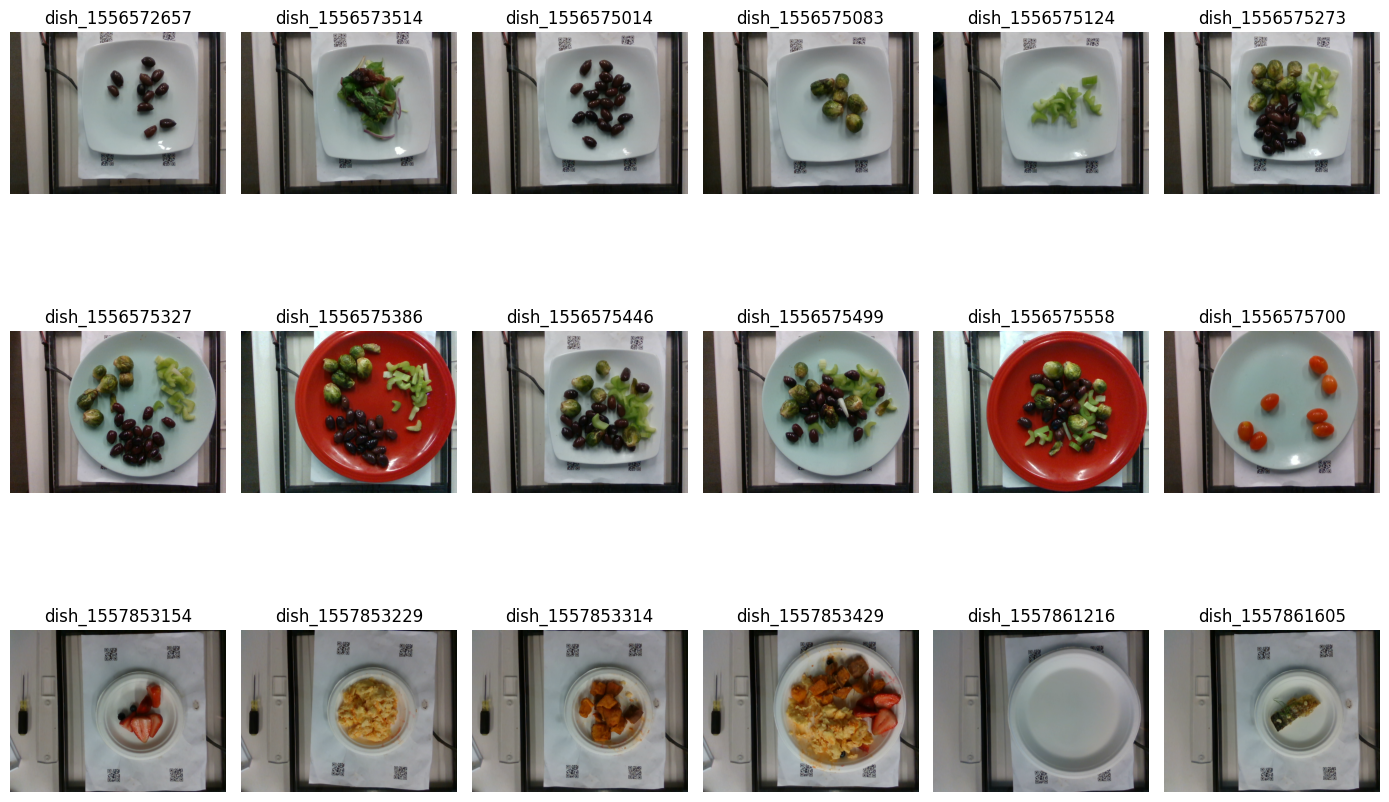

In [7]:
# Загрузка датасета с картинками
image_dataset_path = PATHS['images_dir']
image_dataset = ImageFolder(image_dataset_path)

fig, axes = plt.subplots(3, 6, figsize=(14, 10))
for i, ax in enumerate(axes.flat):
    image, label = image_dataset[i]
    ax.imshow(image)
    ax.set_title(image_dataset.classes[label])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [8]:
len(image_dataset)

3490

Выглядит понятно, нормально, будем аугментировать.

In [9]:
# Загрузка датасетов с табличными данными
dish_dataset_path = PATHS['dish_csv']
dish_dataset = pd.read_csv(dish_dataset_path)

ingr_dataset_path = PATHS['ingredients_csv']
ingr_dataset = pd.read_csv(ingr_dataset_path)

In [10]:
print(ingr_dataset.head(5))
print('\n\n')
print('Инфо о данных с ингредиентами:')
print(ingr_dataset.info())
print('\n\n')
print('Пропуски в данных с ингредиентами:')
print(ingr_dataset.isna().sum())

   id            ingr
0   1  cottage cheese
1   2    strawberries
2   3    garden salad
3   4           bacon
4   5        potatoes



Инфо о данных с ингредиентами:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      555 non-null    int64 
 1   ingr    555 non-null    object
dtypes: int64(1), object(1)
memory usage: 8.8+ KB
None



Пропуски в данных с ингредиентами:
id      0
ingr    0
dtype: int64


Опытным путем в ходе работы было выявлено, что есть какие-то строки, где ингредиент записан как deprecated. Сразу заменим это на "Unknown ingredient"

In [11]:
deprecated = ingr_dataset[ingr_dataset['ingr'] == 'deprecated']
deprecated

id        ingr
230  231  deprecated
452  453  deprecated
457  458  deprecated
469  470  deprecated

In [12]:
ingr_dataset['ingr'] = ingr_dataset['ingr'].replace('deprecated', 'Unknown ingredient')

Здесь все нормально. Посмотрим на датасе с блюдами.

In [13]:
print(dish_dataset.head(5))
print('\n\n')
print('Базовое инфо о данных с блюдами:')
print(dish_dataset.info())

print('Статистика по данным с блюдами:')
print(dish_dataset.describe())


print('\n\n')
print('Пропуски в данных с блюдами:')
print(dish_dataset.isna().sum())

           dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test  
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train  
2  ingr_0000000448;ingr_0000000520;ingr_000000046...   test  
3    ingr_0000000471;ingr_0000000031;ingr_0000000347  train  
4                                    ingr_0000000453  train  



Базовое инфо о данных с блюдами:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dish_id         3262 non-null   object 
 1   total_calories  3262 non-null   float64
 2   

In [14]:
dish_dataset['split'].value_counts()

split
train    2755
test      507
Name: count, dtype: int64

Типы данных менять на float16 не будем, памяти скорее всего хватит. Но правки в несем в колонку с ингредиентами. Сранвеям в колонкой id в Ingr_dataset через регулярку.

In [15]:
print(ingr_dataset['id'].min())
print(ingr_dataset['id'].max())

1
555


In [16]:
dish_dataset['ingredients'] = dish_dataset['ingredients'].str.replace(r'[^0-9;,]', '', regex=True)
dish_dataset['ingredients'] = dish_dataset['ingredients'].str.replace(r'(^|;)0+(?=\d)', r'\1', regex=True)

In [17]:
dish_dataset.head(5)

dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  
0  508;122;26;524;94;23;189;54;29;328;291;520;161...   test  
1  312;26;29;122;508;513;520;525;161;94;189;43;46...  train  
2   448;520;462;514;152;312;291;45;122;6;161;524;116   test  
3                                         471;31;347  train  
4                                                453  train

In [18]:
# Создаем словарь id -> название ингредиента
ingr_dict = dict(zip(ingr_dataset['id'], ingr_dataset['ingr']))

# Функция для замены id на названия
def get_ingredients_names(ingredients_str):
    ids = ingredients_str.split(';')
    names = [ingr_dict.get(int(id), f'Unknown_{id}') for id in ids]
    return '; '.join(names)

# Создаем новую колонку
dish_dataset['dish_description'] = dish_dataset['ingredients'].apply(get_ingredients_names)

In [19]:
dish_dataset.head(5)

dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  \
0  508;122;26;524;94;23;189;54;29;328;291;520;161...   test   
1  312;26;29;122;508;513;520;525;161;94;189;43;46...  train   
2   448;520;462;514;152;312;291;45;122;6;161;524;116   test   
3                                         471;31;347  train   
4                                                453  train   

                                    dish_description  
0  soy sauce; garlic; white rice; parsley; onions...  
1  pepper; white rice; mixed greens; garlic; soy ...  
2  jalapenos; lemon juice; pork; wheat berry; cab...  
3           cherry tomatoes; cucumbers; baby carrots  
4                                 Unknown ingredient

Сравним что-то одно, посмотрим, совпадает или нет

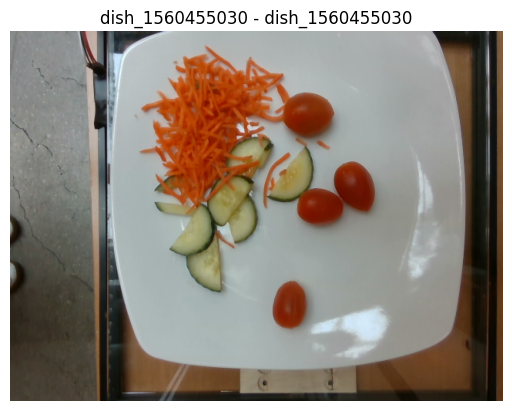

In [20]:
# Найти индекс изображения по имени файла
img_name = 'dish_1560455030'
for idx, (path, _) in enumerate(image_dataset.imgs):
    if img_name in path:
        img, label = image_dataset[idx]
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{img_name} - {image_dataset.classes[label]}')
        plt.show()
        break

Свизуализируем, что за неизвестные ингредиенты, может, можно заполнить это каким-то осмысленным значением.

In [21]:
deprecated = dish_dataset[dish_dataset['dish_description'].str.contains('Unknown', na=False)]
deprecated

dish_id  total_calories  total_mass       ingredients  split  \
4     dish_1558372433       74.360001       143.0               453  train   
55    dish_1558114086       74.360001       143.0               453   test   
123   dish_1558027001       20.400002        68.0               458  train   
334   dish_1558373159     1013.337036       334.0         39;453;77   test   
594   dish_1558115364      485.260010       313.0        5;453;77;4  train   
701   dish_1558114875       74.360001       143.0               453  train   
749   dish_1558375506       73.839996       142.0               453  train   
908   dish_1558028142       21.900002        73.0               458  train   
1025  dish_1558031019      206.442001       197.0     192;4;458;112  train   
1068  dish_1558030724       18.300001        61.0               458  train   
1124  dish_1558109945       74.360001       143.0               453  train   
1144  dish_1558027243      263.364990       163.0         458;4;192  train   
1331  dish_1558373074       73.839996       142.0               453   test   
1428  dish_1558379876     1148.250977       374.0         453;39;77  train   
1499  dish_1558115282       74.879997       144.0               453  train   
1511  dish_1558379588       74.360001       143.0               453  train   
1685  dish_1558376984      671.678040       350.0  77;453;39;29;440   test   
1794  dish_1558028606       19.500000        65.0               458  train   
1823  dish_1558122740      260.149994       304.0    440;29;453;5;4  train   
1861  dish_1558116547       74.879997       144.0               453  train   
1880  dish_1558115047      203.699997       212.0         29;77;453  train   
1890  dish_1558380152       74.360001       143.0               453  train   
2112  dish_1558375583      386.134003       251.0         29;39;453  train   
2243  dish_1558031394      237.410004       318.0      37;458;5;192   test   
2316  dish_1558114284      162.230011       316.0        453;440;37   test   
2456  dish_1558028772       64.000000       192.0        458;112;37  train   
2460  dish_1558031351       12.300000        41.0               458   test   
2485  dish_1558376768       74.360001       143.0               453   test   
2486  dish_1558372771      522.609985       311.0     453;440;39;77  train   
2569  dish_1558380181      374.936005       313.0        77;453;440  train   
3081  dish_1558028194      228.050003       172.0           4;458;5  train   

                                       dish_description  
4                                    Unknown ingredient  
55                                   Unknown ingredient  
123                                  Unknown ingredient  
334                sausage; Unknown ingredient; almonds  
594        potatoes; Unknown ingredient; almonds; bacon  
701                                  Unknown ingredient  
749                                  Unknown ingredient  
908                                  Unknown ingredient  
1025    yam; bacon; Unknown ingredient; honeydew melons  
1068                                 Unknown ingredient  
1124                                 Unknown ingredient  
1144                     Unknown ingredient; bacon; yam  
1331                                 Unknown ingredient  
1428               Unknown ingredient; sausage; almonds  
1499                                 Unknown ingredient  
1511                                 Unknown ingredient  
1685  almonds; Unknown ingredient; sausage; mixed gr...  
1794                                 Unknown ingredient  
1823  grapes; mixed greens; Unknown ingredient; pota...  
1861                                 Unknown ingredient  
1880          mixed greens; almonds; Unknown ingredient  
1890                                 Unknown ingredient  
2112          mixed greens; sausage; Unknown ingredient  
2243      cantaloupe; Unknown ingredient; potatoes; yam  
2316             Unknown ingredient; grapes; cantaloupe  
2456    U

231 и 470 не используются. нам надо определить только 453 и 453

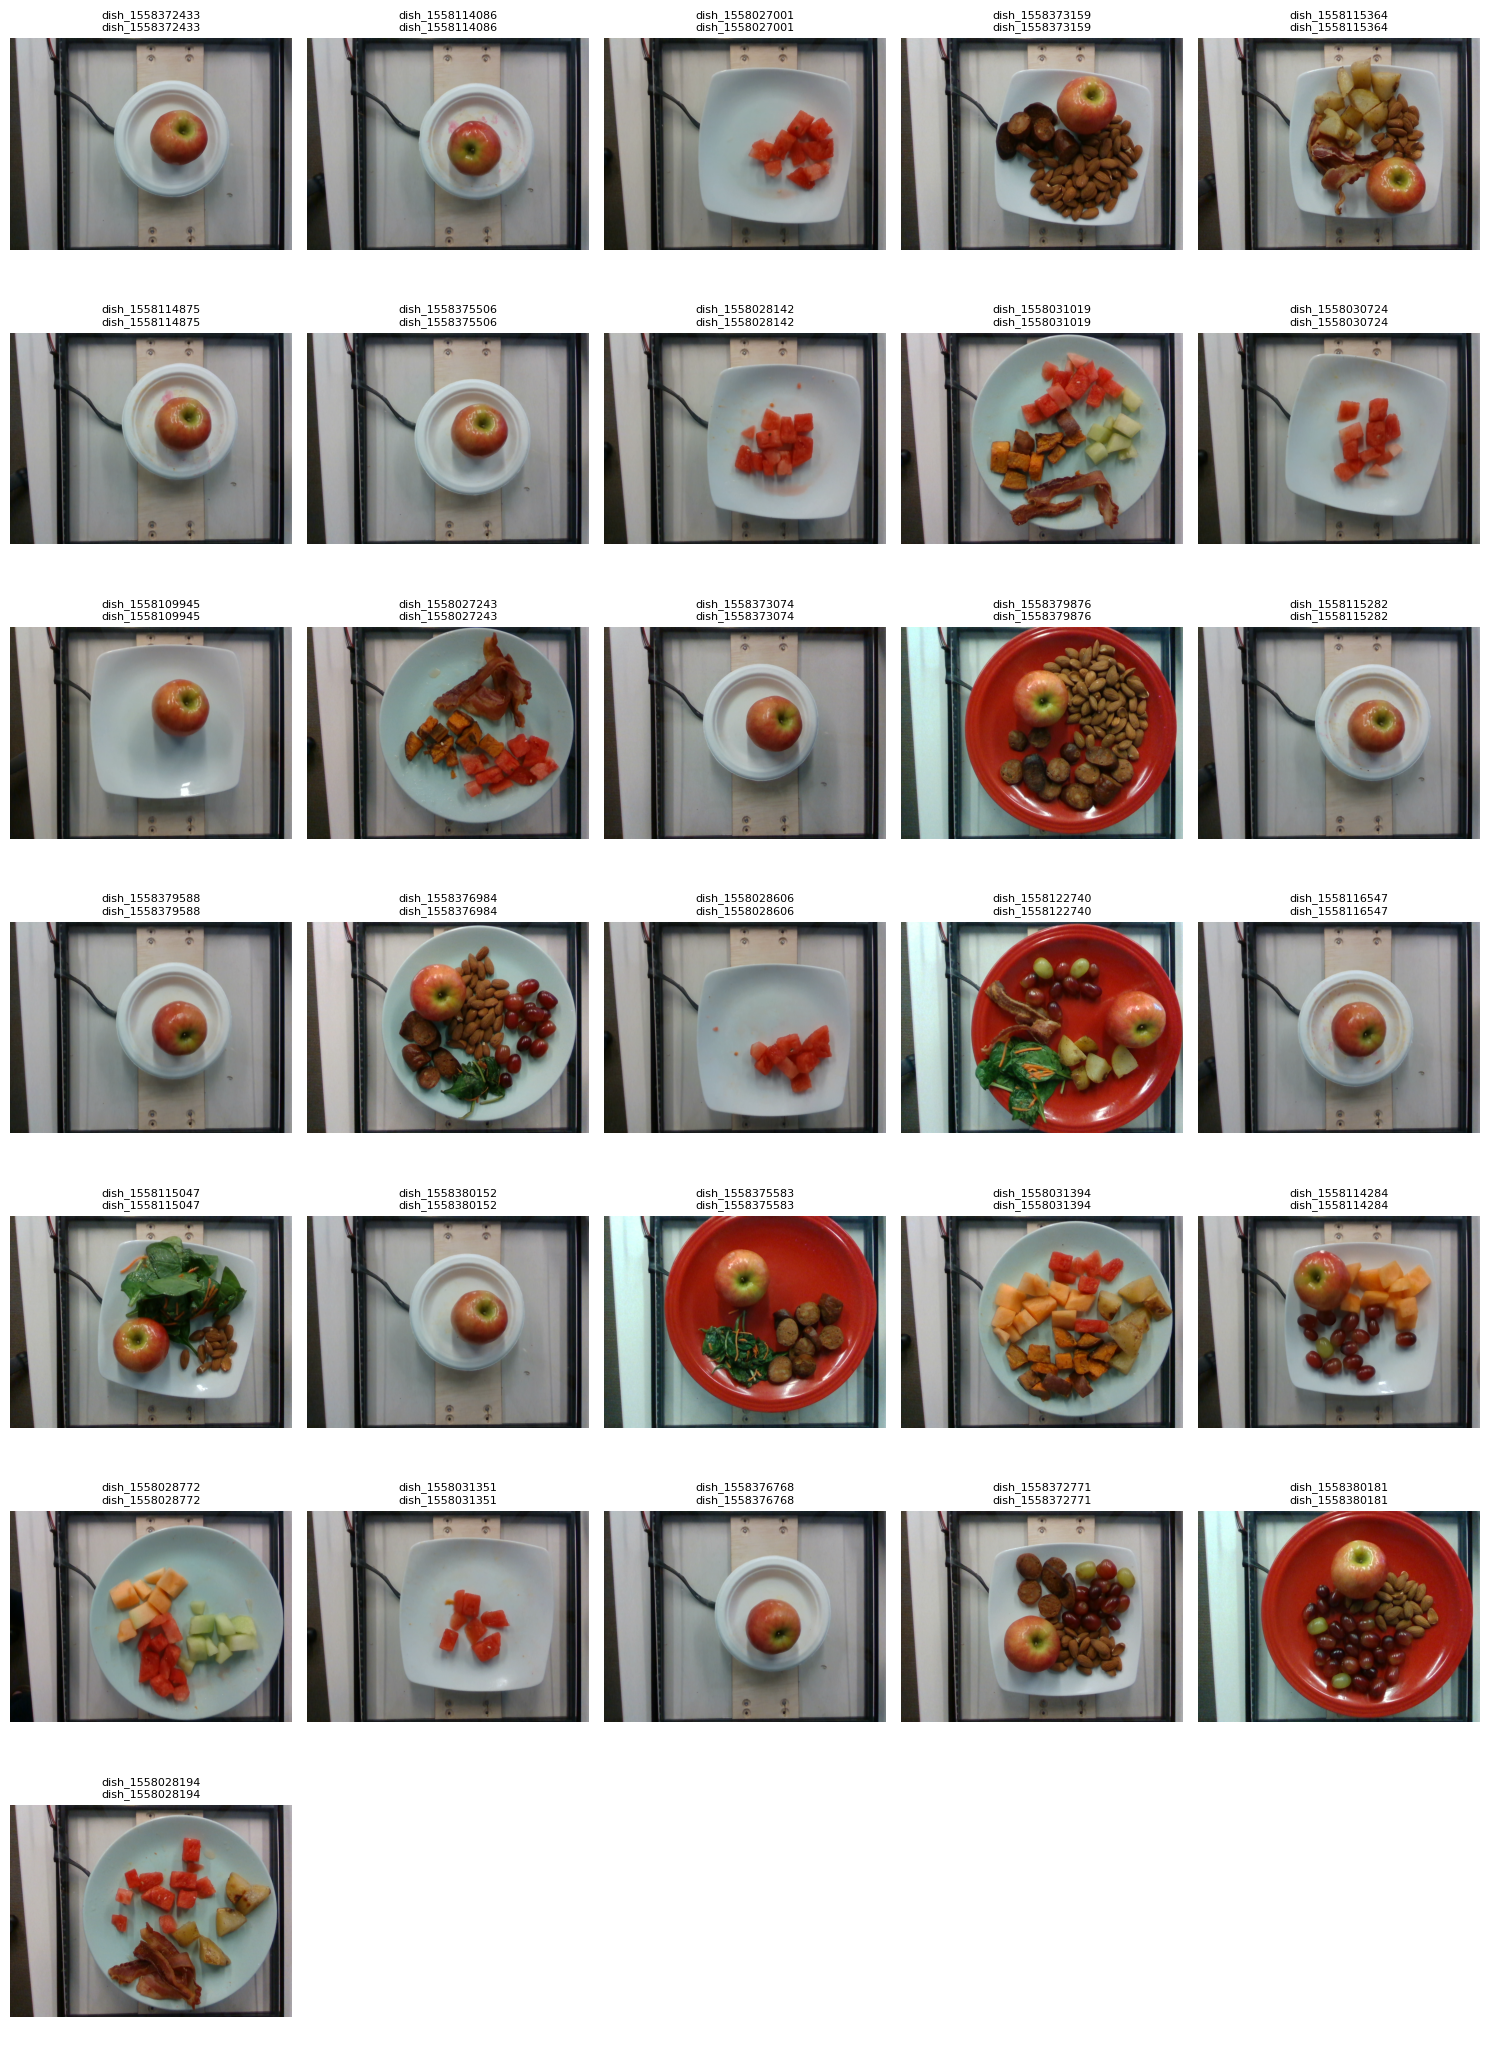

In [22]:
deprecated = dish_dataset[dish_dataset['dish_description'].str.contains('Unknown', na=False)]

n = len(deprecated)
cols = 5
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()

for plot_idx, (_, row) in enumerate(deprecated.iterrows()):
    img_name = row['dish_id']
    
    # Ищем изображение в image_dataset
    for idx, (path, _) in enumerate(image_dataset.imgs):
        if img_name in path:
            img, label = image_dataset[idx]
            axes[plot_idx].imshow(img)
            axes[plot_idx].set_title(f"{img_name}\n{image_dataset.classes[label]}", fontsize=8)
            axes[plot_idx].axis('off')
            break

# Скрыть пустые subplots
for i in range(n, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

453 - яблоко, 458 - арбуз

In [23]:
def replace_unknown_ingredients(row):
    description = row['dish_description']
    ingredients = row['ingredients']
    
    if 'Unknown ingredient' in description:
        ids = [int(x) for x in ingredients.split(';')]
        replacements = []
        
        if 453 in ids:
            replacements.append('apple')
        if 458 in ids:
            replacements.append('watermelon')
        
        # Заменяем каждое Unknown ingredient по порядку
        for replacement in replacements:
            description = description.replace('Unknown ingredient', replacement, 1)
    
    return description

dish_dataset['dish_description'] = dish_dataset.apply(replace_unknown_ingredients, axis=1)

In [24]:
dish_dataset.head(5)

dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  \
0  508;122;26;524;94;23;189;54;29;328;291;520;161...   test   
1  312;26;29;122;508;513;520;525;161;94;189;43;46...  train   
2   448;520;462;514;152;312;291;45;122;6;161;524;116   test   
3                                         471;31;347  train   
4                                                453  train   

                                    dish_description  
0  soy sauce; garlic; white rice; parsley; onions...  
1  pepper; white rice; mixed greens; garlic; soy ...  
2  jalapenos; lemon juice; pork; wheat berry; cab...  
3           cherry tomatoes; cucumbers; baby carrots  
4                                              apple

In [25]:
apple_watermelon_check = dish_dataset[dish_dataset['dish_description'].str.contains(r'\bapple\b|\bwatermelon\b', na=False, regex=True)]
apple_watermelon_check.head(10)

dish_id  total_calories  total_mass  \
0   dish_1561662216      300.794281       193.0   
1   dish_1561662054      419.438782       292.0   
4   dish_1558372433       74.360001       143.0   
9   dish_1565972591      195.199997       122.0   
19  dish_1563468327      351.886047       483.0   
42  dish_1567613057      406.686310       749.0   
50  dish_1558459115      271.540009       298.0   
51  dish_1558723777       74.360001       143.0   
55  dish_1558114086       74.360001       143.0   
56  dish_1558720236      887.823059       407.0   

                                          ingredients  split  \
0   508;122;26;524;94;23;189;54;29;328;291;520;161...   test   
1   312;26;29;122;508;513;520;525;161;94;189;43;46...  train   
4                                                 453  train   
9                                                 510  train   
19                            192;437;1;38;121;161;13  train   
42                                161;128;121;437;475  train   
50                                   77;54;26;471;440  train   
51                                                 54  train   
55                                                453   test   
56                                         54;45;7;77   test   

                                     dish_description  
0   soy sauce; garlic; white rice; parsley; onions...  
1   pepper; white rice; mixed greens; garlic; soy ...  
4                                               apple  
9                               chicken apple sausage  
19  yam; sweet potato; cottage cheese; pineapple; ...  
42  olive oil; egg whites; watermelon; sweet potat...  
50  almonds; apple; white rice; cherry tomatoes; g...  
51                                              apple  
55                                              apple  
56                apple; carrot; cauliflower; almonds

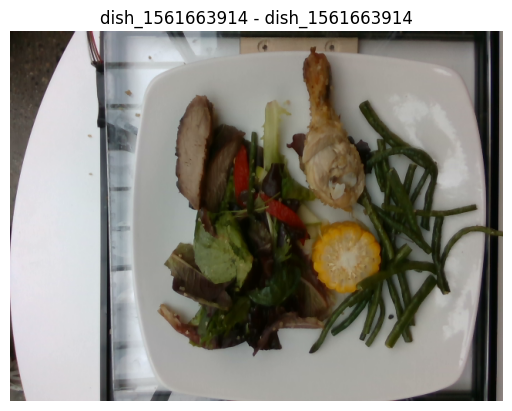

In [26]:
# Найти индекс изображения по имени файла
img_name = 'dish_1561663914'
for idx, (path, _) in enumerate(image_dataset.imgs):
    if img_name in path:
        img, label = image_dataset[idx]
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{img_name} - {image_dataset.classes[label]}')
        plt.show()
        break

In [27]:
unknown = dish_dataset[dish_dataset['dish_description'].str.contains('Unknown', na=False, regex=True)]
unknown

Empty DataFrame
Columns: [dish_id, total_calories, total_mass, ingredients, split, dish_description]
Index: []

Также были блюда с нулевыв калоражем и минимальным весом. Помотрим на них.

In [28]:
zero_calories = dish_dataset[dish_dataset['total_calories'] == 0]
zero_calories

dish_id  total_calories  total_mass ingredients  split  \
263   dish_1557861216             0.0         1.0         423   test   
2652  dish_1556575700             0.0        86.0         423  train   

     dish_description  
263        plate only  
2652       plate only

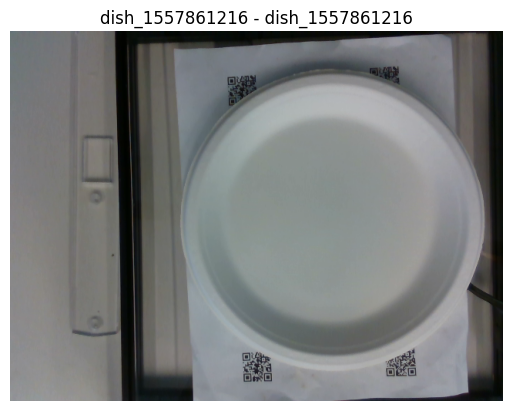

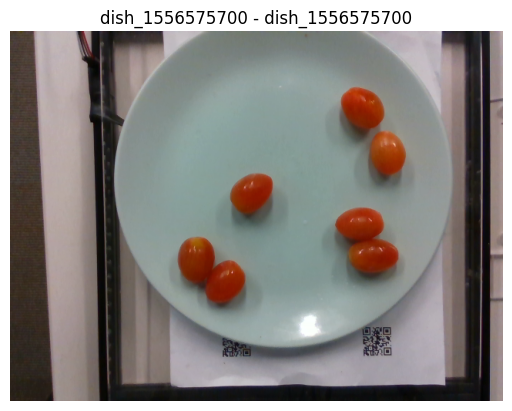

In [29]:
# Найти индекс изображения по имени файла
img_name = 'dish_1557861216'
for idx, (path, _) in enumerate(image_dataset.imgs):
    if img_name in path:
        img, label = image_dataset[idx]
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{img_name} - {image_dataset.classes[label]}')
        plt.show()
        break


    # Найти индекс изображения по имени файла
img_name = 'dish_1556575700'
for idx, (path, _) in enumerate(image_dataset.imgs):
    if img_name in path:
        img, label = image_dataset[idx]
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{img_name} - {image_dataset.classes[label]}')
        plt.show()
        break

Пустую тарелку оставим, но во втором случае Надо заменить на ингредиент 471 - cherry tomatoes. И посмотрим, сколько туда калорий поставить.

In [30]:
cherry_tomatoes = dish_dataset[dish_dataset['dish_description'] == 'cherry tomatoes']
cherry_tomatoes

dish_id  total_calories  total_mass ingredients  split  \
21    dish_1558549008       20.700001       115.0         471  train   
152   dish_1558723926       19.260000       107.0         471  train   
173   dish_1558721484       11.160001        62.0         471  train   
200   dish_1558641075       12.420000        69.0         471  train   
329   dish_1558641954       18.360001       102.0         471  train   
625   dish_1558723073       16.200001        90.0         471  train   
728   dish_1558636928       16.020000        89.0         471  train   
1248  dish_1558721380       19.260000       107.0         471  train   
1399  dish_1558463362       20.880001       116.0         471  train   
1545  dish_1558461760       10.980000        61.0         471   test   
1573  dish_1567106594       15.840000        88.0         471  train   
1584  dish_1558459528       11.520000        64.0         471  train   
1667  dish_1558639673       16.020000        89.0         471  train   
1803  dish_1565808943       13.320001        74.0         471  train   
1925  dish_1558638896       22.680000       126.0         471  train   
2004  dish_1558639662       16.020000        89.0         471  train   
2035  dish_1560368110       16.020000        89.0         471  train   
2100  dish_1558632959       16.020000        89.0         471  train   
2185  dish_1558636514       16.020000        89.0         471  train   
2229  dish_1558639907       10.440001        58.0         471  train   
2259  dish_1558641287       11.520000        64.0         471   test   
2261  dish_1558639683       16.020000        89.0         471  train   
2341  dish_1558459020       10.980000        61.0         471  train   
2444  dish_1558722842       10.440001        58.0         471  train   
2659  dish_1558721959       11.160001        62.0         471  train   
2663  dish_1560454970        9.900001        55.0         471  train   
2702  dish_1562701956        6.840000        38.0         471  train   
2738  dish_1558640563        4.140000        23.0         471  train   
2798  dish_1558460138       10.080000        56.0         471  train   
2927  dish_1558640238       22.680000       126.0         471  train   
2930  dish_1558722707       19.260000       107.0         471  train   
2943  dish_1560366963        7.560000        42.0         471  train   
2991  dish_1558631872       16.020000        89.0         471  train   
3006  dish_1558719097       19.260000       107.0         471  train   
3073  dish_1564773826       10.080000        56.0         471   test   
3108  dish_1558462531       12.960001        72.0         471  train   
3246  dish_1558722434        8.460000        47.0         471  train   

     dish_description  
21    cherry tomatoes  
152   cherry tomatoes  
173   cherry tomatoes  
200   cherry tomatoes  
329   cherry tomatoes  
625   cherry tomatoes  
728   cherry tomatoes  
1248  cherry tomatoes  
1399  cherry tomatoes  
1545  cherry tomatoes  
1573  cherry tomatoes  
1584  cherry tomatoes  
1667  cherry tomatoes  
1803  cherry tomatoes  
1925  cherry tomatoes  
2004  cherry tomatoes  
2035  cherry tomatoes  
2100  cherry tomatoes  
2185  cherry tomatoes  
2229  cherry tomatoes  
2259  cherry tomatoes  
2261  cherry tomatoes  
2341  cherry tomatoes  
2444  cherry tomatoes  
2659  cherry tomatoes  
2663  cherry tomatoes  
2702  cherry tomatoes  
2738  cherry tomatoes  
2798  cherry tomatoes  
2927  cherry tomatoes  
2930  cherry tomatoes  
2943  cherry tomatoes  
2991  cherry tomatoes  
3006  cherry tomatoes  
3073  cherry tomatoes  
3108  cherry tomatoes  
3246  cherry tomatoes

In [31]:
dish_dataset.loc[dish_dataset['dish_id'] == 'dish_1556575700', 'ingredients'] = '471'
dish_dataset.loc[dish_dataset['dish_id'] == 'dish_1556575700', 'dish_description'] = 'cherry tomatoes'
dish_dataset.loc[dish_dataset['dish_id'] == 'dish_1556575700', 'total_calories'] = '15.0'

/tmp/ipykernel_21763/844310165.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dish_dataset.loc[dish_dataset['dish_id'] == 'dish_1556575700', 'total_calories'] = '15.0'


In [32]:
zero_calories = dish_dataset[dish_dataset['total_calories'] == 0]
zero_calories

dish_id total_calories  total_mass ingredients split  \
263  dish_1557861216            0.0         1.0         423  test   

    dish_description  
263       plate only

In [33]:
# Создаём папку если её нет
os.makedirs(PATHS['processed_dir'], exist_ok=True)

# Сохраняем датафрейм
dish_dataset.to_csv(PATHS['processed_dish'], index=False)
print(f"Датафрейм сохранён: {PATHS['processed_dish']}")

Датафрейм сохранён: /home/ubuntu/multimodal_calorie_count/data/processed/dish_dataset.csv


## Сформируем видение

### Как будем решать задачу?

Так как наша цель состоит в том, чтобы получить DL-модель, способную оценить калорийность блюда, а данные у нас есть и картиночные, и текстовые, то построим мультимодальную систему. 

### Архитектура модели

- Картиночную часть попробуем взять либо сверточной (CNN), либо трансформером (ViT) — посмотрим, что будет быстрее, эффективнее, и где будет баланс
- Эмбеддинг ингредиентов получим через BERT
- Перемножим эмбеддинги текста и картинки и также линейную проекцию массы блюда и подадим это всё в регрессионную сеть
- На выходе получим непрерывное значение калорийности

### Какие подходы к обогащению/аугментации данных применим и почему?

Попробуем обогатить данные через следующие техники:

Для изображений:
- Повороты, отражения, обрезки
- Контраст, засветы, размытия 
- Color jittering для адаптации к различным цветовым условиям
- Random erasing для имитации частично перекрытого блюда
- Вставки каких-нибудь квадратиков для разнообразия (мало ли кто пальцем закроет блюдо)

Это нужно, потому что ожидается, что пользователи будут отправлять фотографии далеко не лучших ракурсов и качества.

Для текста попробуем:
- Замена ингредиентов на синонимы (например, "cherry tomatoes" ="small tomatoes")
- Back-translation через multilingual BERT

*Опытном путем было проверено, что текстовая аугментация только мусорит, так что от нее отказалась.*


### На какие метрики будем ориентироваться при обучении?

Основные метрики:
- MAE - средняя абсолютная ошибка; модель будет считаться готовой к интеграции в продукт при MAE < 50 ккал на тестовой выборке
- MSE - для учёта больших выбросов (у нас нету, ну мало ли кто там что навводит)
- R^2 для понимая, что понимает модель

In [34]:
dish_dataset = pd.read_csv(PATHS['processed_dish'])

In [35]:
dish_dataset.head(5)

dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  \
0  508;122;26;524;94;23;189;54;29;328;291;520;161...   test   
1  312;26;29;122;508;513;520;525;161;94;189;43;46...  train   
2   448;520;462;514;152;312;291;45;122;6;161;524;116   test   
3                                         471;31;347  train   
4                                                453  train   

                                    dish_description  
0  soy sauce; garlic; white rice; parsley; onions...  
1  pepper; white rice; mixed greens; garlic; soy ...  
2  jalapenos; lemon juice; pork; wheat berry; cab...  
3           cherry tomatoes; cucumbers; baby carrots  
4                                              apple

###  Конфигурация

In [36]:
#  Конфигурация


def seed_everything(seed: int):
    """Установка seed для воспроизводимости"""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def set_requires_grad(module: nn.Module, unfreeze_pattern="", verbose=False):
    """Заморозка/разморозка слоёв по паттерну"""
    if len(unfreeze_pattern) == 0:
        for _, param in module.named_parameters():
            param.requires_grad = False
        return
    
    pattern = unfreeze_pattern.split("|")
    for name, param in module.named_parameters():
        if any([name.startswith(p) for p in pattern]):
            param.requires_grad = True
            if verbose:
                print(f"Разморожен слой: {name}")
        else:
            param.requires_grad = False

class Config:
    # Seed
    SEED = 42
    
    # Модели
    TEXT_MODEL_NAME = "bert-base-uncased"
    IMAGE_MODEL_NAME = "tf_efficientnet_b7"  # или tf_efficientnet_b0 для быстрого обучения
    
    # Заморозка слоёв (пустая строка = заморозить все)
    TEXT_MODEL_UNFREEZE = "encoder.layer.10|encoder.layer.11|pooler"  # Размораживаем последние 2 слоя BERT
    IMAGE_MODEL_UNFREEZE = "blocks.6|conv_head|bn2"  # Размораживаем последние блоки EfficientNet
    
    # Гиперпараметры
    BATCH_SIZE = 32
    TEXT_LR = 3e-5
    IMAGE_LR = 1e-4
    REGRESSOR_LR = 1e-3
    EPOCHS = 50
    DROPOUT = 0.3
    HIDDEN_DIM = 512
    
    # Пути
    PROCESSED_DATA_PATH = PATHS['processed_dish']
    IMAGES_DIR = PATHS['images_dir']
    SAVE_PATH = PATHS['best_model']
    LOG_PATH = PATHS['logs_dir']
    
    # Ранняя остановка
    PATIENCE = 10
    MIN_DELTA = 1.0

# Инициализация
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg = Config()
seed_everything(cfg.SEED)

print(f"Seed установлен: {cfg.SEED}")
print(f"Устройство: {device}")
print(f"Text model: {cfg.TEXT_MODEL_NAME}")
print(f"Image model: {cfg.IMAGE_MODEL_NAME}")

Seed установлен: 42
Устройство: cuda
Text model: bert-base-uncased
Image model: tf_efficientnet_b7


###  Dataset

In [37]:
#  Dataset с правильной структурой путей


class CalorieDataset(Dataset):
    def __init__(self, dataframe, images_dir, config, tokenizer, transform=None):
        self.data = dataframe.reset_index(drop=True)
        self.images_dir = images_dir
        self.config = config
        self.tokenizer = tokenizer
        self.transform = transform
        
        # Проверяем наличие изображений
        print("Проверка наличия изображений...")
        missing = []
        for dish_id in self.data['dish_id']:
            img_path = os.path.join(self.images_dir, dish_id, 'rgb.png')
            if not os.path.exists(img_path):
                missing.append(dish_id)
        
        if missing:
            print(f"Внимание: {len(missing)} изображений не найдено")
            print(f"Примеры отсутствующих: {missing[:5]}")
            # Удаляем строки с отсутствующими изображениями
            self.data = self.data[~self.data['dish_id'].isin(missing)].reset_index(drop=True)
            print(f"Датасет очищен: осталось {len(self.data)} примеров")
        else:
            print(f"Все {len(self.data)} изображений найдены")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Загрузка изображения (структура: images_dir/dish_id/rgb.png)
        img_name = row['dish_id']
        img_path = os.path.join(self.images_dir, img_name, 'rgb.png')
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Токенизация текста
        ingredients = row['dish_description']
        tokens = self.tokenizer(
            ingredients,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )
        
        # Масса и калории
        mass = torch.tensor(row['total_mass'], dtype=torch.float32)
        calories = torch.tensor(row['total_calories'], dtype=torch.float32)
        
        return {
            'image': image,
            'input_ids': tokens['input_ids'].squeeze(0),
            'attention_mask': tokens['attention_mask'].squeeze(0),
            'mass': mass,
            'calories': calories,
            'dish_id': img_name
        }

### DataLoader

In [38]:
# Создание DataLoader

# Загрузка токенизатора
tokenizer = AutoTokenizer.from_pretrained(cfg.TEXT_MODEL_NAME)

# Разделение данных
train_df = dish_dataset[dish_dataset['split'] == 'train'].copy()
test_df = dish_dataset[dish_dataset['split'] == 'test'].copy()

# Трансформации
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Создание датасетов
train_dataset = CalorieDataset(train_df, cfg.IMAGES_DIR, cfg, tokenizer, transform=train_transform)
test_dataset = CalorieDataset(test_df, cfg.IMAGES_DIR, cfg, tokenizer, transform=test_transform)

# Создание загрузчиков
train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train batches: {len(train_loader)} ({len(train_dataset)} samples)")
print(f"Test batches: {len(test_loader)} ({len(test_dataset)} samples)")

Проверка наличия изображений...
Все 2755 изображений найдены
Проверка наличия изображений...
Все 507 изображений найдены
Train batches: 87 (2755 samples)
Test batches: 16 (507 samples)


###  Архитектура модели

In [39]:
#  Архитектура модели

class CalorieEstimationModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        # Text encoder (BERT)
        self.text_model = AutoModel.from_pretrained(config.TEXT_MODEL_NAME)
        
        # Image encoder (EfficientNet)
        self.image_model = timm.create_model(
            config.IMAGE_MODEL_NAME,
            pretrained=True,
            num_classes=0
        )
        
        # Projection layers
        self.text_proj = nn.Linear(self.text_model.config.hidden_size, config.HIDDEN_DIM)
        self.image_proj = nn.Linear(self.image_model.num_features, config.HIDDEN_DIM)
        self.mass_proj = nn.Linear(1, config.HIDDEN_DIM)
        
        # Fusion + Regression head
        self.regressor = nn.Sequential(
            nn.Linear(config.HIDDEN_DIM, config.HIDDEN_DIM // 2),
            nn.LayerNorm(config.HIDDEN_DIM // 2),
            nn.ReLU(),
            nn.Dropout(config.DROPOUT),
            nn.Linear(config.HIDDEN_DIM // 2, config.HIDDEN_DIM // 4),
            nn.ReLU(),
            nn.Dropout(config.DROPOUT / 2),
            nn.Linear(config.HIDDEN_DIM // 4, 1),
            nn.ReLU()  # Калории не могут быть отрицательными
        )
        
    def forward(self, image, ingredients, mass):
        # Получение эмбеддингов
        text_features = self.text_model(**ingredients).last_hidden_state[:, 0, :]  # [CLS] token
        image_features = self.image_model(image)
        
        # Проекция в общее пространство
        text_emb = self.text_proj(text_features)
        image_emb = self.image_proj(image_features)
        mass_emb = self.mass_proj(mass)
        
        # Early fusion (конкатенация + взаимодействие)
        fused_emb = text_emb * image_emb * mass_emb
        
        # Предсказание калорий
        calories = self.regressor(fused_emb)
        return calories

### Функция обучения

In [40]:
#  Функция обучения


def train(config, device):
    """
    Функция обучения и валидации модели
    
    Args:
        config: Конфигурация обучения
        device: Устройство (CPU/CUDA)
    
    Returns:
        history: История обучения с метриками
    """
    print(f"\n{'='*80}")
    print(f"ИНИЦИАЛИЗАЦИЯ МОДЕЛИ")
    print(f"{'='*80}\n")
    
    # Создание необходимых папок
    os.makedirs(os.path.dirname(config.SAVE_PATH), exist_ok=True)
    os.makedirs(config.LOG_PATH, exist_ok=True)
    
    # Инициализация модели
    model = CalorieEstimationModel(config).to(device)
    
    # Заморозка/разморозка слоёв
    print("Настройка заморозки слоёв...")
    set_requires_grad(model.text_model, unfreeze_pattern=config.TEXT_MODEL_UNFREEZE, verbose=True)
    set_requires_grad(model.image_model, unfreeze_pattern=config.IMAGE_MODEL_UNFREEZE, verbose=True)
    
    # Оптимизатор с разными learning rates для разных частей
    optimizer = AdamW([
        {'params': model.text_model.parameters(), 'lr': config.TEXT_LR},
        {'params': model.image_model.parameters(), 'lr': config.IMAGE_LR},
        {'params': model.regressor.parameters(), 'lr': config.REGRESSOR_LR},
        {'params': model.text_proj.parameters(), 'lr': config.REGRESSOR_LR},
        {'params': model.image_proj.parameters(), 'lr': config.REGRESSOR_LR},
        {'params': model.mass_proj.parameters(), 'lr': config.REGRESSOR_LR}
    ])
    
    # Функция потерь
    criterion = nn.MSELoss()
    
    # История обучения
    history = {
        'epoch': [],
        'train_loss': [],
        'train_mae': [],
        'train_mse': [],
        'train_r2': [],
        'val_loss': [],
        'val_mae': [],
        'val_mse': [],
        'val_r2': [],
        'val_mae_under_30': [],
        'val_mae_under_50': [],
        'val_mae_under_100': []
    }
    
    # Ранняя остановка
    best_val_mae = float('inf')
    patience_counter = 0
    
    print(f"\n{'='*80}")
    print(f"НАЧАЛО ОБУЧЕНИЯ")
    print(f"{'='*80}\n")
    
    for epoch in range(config.EPOCHS):
        # ==================== ОБУЧЕНИЕ ====================
        model.train()
        train_losses = []
        train_preds = []
        train_targets = []
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.EPOCHS} [Train]")
        for batch_idx, batch in enumerate(pbar):
            # Получение данных
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            mass = batch['mass'].to(device).unsqueeze(1)
            calories = batch['calories'].to(device).unsqueeze(1)
            
            # Подготовка входа для BERT
            ingredients = {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }
            
            # Прямой проход
            optimizer.zero_grad()
            predictions = model(images, ingredients, mass)
            loss = criterion(predictions, calories)
            
            # Обратный проход
            loss.backward()
            optimizer.step()
            
            # Сохранение метрик
            train_losses.append(loss.item())
            train_preds.extend(predictions.detach().cpu().numpy().flatten())
            train_targets.extend(calories.detach().cpu().numpy().flatten())
            
            # Обновление прогресс-бара
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Вычисление метрик обучения
        train_loss = np.mean(train_losses)
        train_mae = mean_absolute_error(train_targets, train_preds)
        train_mse = mean_squared_error(train_targets, train_preds)
        train_r2 = r2_score(train_targets, train_preds)
        
        # ==================== ВАЛИДАЦИЯ ====================
        model.eval()
        val_losses = []
        val_preds = []
        val_targets = []
        
        with torch.no_grad():
            for batch in tqdm(test_loader, desc=f"Epoch {epoch+1}/{config.EPOCHS} [Val]"):
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                mass = batch['mass'].to(device).unsqueeze(1)
                calories = batch['calories'].to(device).unsqueeze(1)
                
                ingredients = {
                    'input_ids': input_ids,
                    'attention_mask': attention_mask
                }
                
                predictions = model(images, ingredients, mass)
                loss = criterion(predictions, calories)
                
                val_losses.append(loss.item())
                val_preds.extend(predictions.cpu().numpy().flatten())
                val_targets.extend(calories.cpu().numpy().flatten())
        
        # Вычисление метрик валидации
        val_loss = np.mean(val_losses)
        val_mae = mean_absolute_error(val_targets, val_preds)
        val_mse = mean_squared_error(val_targets, val_preds)
        val_r2 = r2_score(val_targets, val_preds)
        
        # Percentile-based metrics
        errors = np.abs(np.array(val_targets) - np.array(val_preds))
        mae_under_30 = (errors < 30).mean() * 100
        mae_under_50 = (errors < 50).mean() * 100
        mae_under_100 = (errors < 100).mean() * 100
        
        # Сохранение истории
        history['epoch'].append(epoch + 1)
        history['train_loss'].append(train_loss)
        history['train_mae'].append(train_mae)
        history['train_mse'].append(train_mse)
        history['train_r2'].append(train_r2)
        history['val_loss'].append(val_loss)
        history['val_mae'].append(val_mae)
        history['val_mse'].append(val_mse)
        history['val_r2'].append(val_r2)
        history['val_mae_under_30'].append(mae_under_30)
        history['val_mae_under_50'].append(mae_under_50)
        history['val_mae_under_100'].append(mae_under_100)
        
        # Вывод метрик
        print(f"\n{'─'*80}")
        print(f"Epoch {epoch+1}/{config.EPOCHS}")
        print(f"{'─'*80}")
        print(f"Train | Loss: {train_loss:.4f} | MAE: {train_mae:.2f} ккал | MSE: {train_mse:.2f} | R²: {train_r2:.4f}")
        print(f"Val   | Loss: {val_loss:.4f} | MAE: {val_mae:.2f} ккал | MSE: {val_mse:.2f} | R²: {val_r2:.4f}")
        print(f"Val   | <30 ккал: {mae_under_30:.1f}% | <50 ккал: {mae_under_50:.1f}% | <100 ккал: {mae_under_100:.1f}%")
        
        # Сохранение лучшей модели
        if val_mae < best_val_mae - config.MIN_DELTA:
            best_val_mae = val_mae
            patience_counter = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_mae': val_mae,
                'config': config,
                'history': history
            }, config.SAVE_PATH)
            print(f"Лучшая модель сохранена (MAE: {val_mae:.2f} ккал)")
        else:
            patience_counter += 1
            print(f"Patience: {patience_counter}/{config.PATIENCE}")
        
        # Ранняя остановка
        if patience_counter >= config.PATIENCE:
            print(f"\n⚠ Ранняя остановка на epoch {epoch+1}")
            break
        
        print(f"{'─'*80}\n")
    
    # Сохранение истории обучения
    history_df = pd.DataFrame(history)
    log_path = os.path.join(config.LOG_PATH, 'training_history.csv')
    history_df.to_csv(log_path, index=False)
    
    print(f"\n{'='*80}")
    print(f"ОБУЧЕНИЕ ЗАВЕРШЕНО")
    print(f"{'='*80}")
    print(f"История обучения сохранена: {log_path}")
    print(f"Лучший результат - Val MAE: {best_val_mae:.2f} ккал")
    print(f"{'='*80}\n")
    
    return history

# Запуск обучения
history = train(cfg, device)


ИНИЦИАЛИЗАЦИЯ МОДЕЛИ



Настройка заморозки слоёв...
Разморожен слой: encoder.layer.10.attention.self.query.weight
Разморожен слой: encoder.layer.10.attention.self.query.bias
Разморожен слой: encoder.layer.10.attention.self.key.weight
Разморожен слой: encoder.layer.10.attention.self.key.bias
Разморожен слой: encoder.layer.10.attention.self.value.weight
Разморожен слой: encoder.layer.10.attention.self.value.bias
Разморожен слой: encoder.layer.10.attention.output.dense.weight
Разморожен слой: encoder.layer.10.attention.output.dense.bias
Разморожен слой: encoder.layer.10.attention.output.LayerNorm.weight
Разморожен слой: encoder.layer.10.attention.output.LayerNorm.bias
Разморожен слой: encoder.layer.10.intermediate.dense.weight
Разморожен слой: encoder.layer.10.intermediate.dense.bias
Разморожен слой: encoder.layer.10.output.dense.weight
Разморожен слой: encoder.layer.10.output.dense.bias
Разморожен слой: encoder.layer.10.output.LayerNorm.weight
Разморожен слой: encoder.layer.10.output.LayerNorm.bias
Разморожен 

Epoch 1/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 1/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 94808.5041 | MAE: 222.06 ккал | MSE: 95299.85 | R²: -0.9519
Val   | Loss: 61681.0574 | MAE: 180.44 ккал | MSE: 62131.84 | R²: -0.3820
Val   | <30 ккал: 11.0% | <50 ккал: 17.9% | <100 ккал: 41.8%
Лучшая модель сохранена (MAE: 180.44 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 2/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 2/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 47542.3795 | MAE: 151.36 ккал | MSE: 47873.31 | R²: 0.0195
Val   | Loss: 29276.3508 | MAE: 115.33 ккал | MSE: 29448.18 | R²: 0.3450
Val   | <30 ккал: 23.7% | <50 ккал: 38.9% | <100 ккал: 60.0%
Лучшая модель сохранена (MAE: 115.33 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 3/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 3/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 26792.2765 | MAE: 103.00 ккал | MSE: 26970.96 | R²: 0.4476
Val   | Loss: 15535.5013 | MAE: 84.20 ккал | MSE: 15620.55 | R²: 0.6525
Val   | <30 ккал: 25.2% | <50 ккал: 45.4% | <100 ккал: 73.6%
Лучшая модель сохранена (MAE: 84.20 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 4/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 4/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 18696.5600 | MAE: 81.16 ккал | MSE: 18817.32 | R²: 0.6146
Val   | Loss: 15380.2837 | MAE: 77.43 ккал | MSE: 15499.78 | R²: 0.6552
Val   | <30 ккал: 39.8% | <50 ккал: 57.2% | <100 ккал: 77.5%
Лучшая модель сохранена (MAE: 77.43 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 5/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.21it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 5/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 15317.6247 | MAE: 70.08 ккал | MSE: 15358.06 | R²: 0.6854
Val   | Loss: 8755.6337 | MAE: 61.30 ккал | MSE: 8798.05 | R²: 0.8043
Val   | <30 ккал: 41.0% | <50 ккал: 60.0% | <100 ккал: 82.4%
Лучшая модель сохранена (MAE: 61.30 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 6/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 6/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 13841.1063 | MAE: 66.47 ккал | MSE: 13981.04 | R²: 0.7136
Val   | Loss: 12935.2023 | MAE: 72.83 ккал | MSE: 13035.65 | R²: 0.7100
Val   | <30 ккал: 43.0% | <50 ккал: 57.8% | <100 ккал: 76.3%
Patience: 1/10
────────────────────────────────────────────────────────────────────────────────



Epoch 7/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 7/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 12578.8919 | MAE: 62.17 ккал | MSE: 12627.97 | R²: 0.7414
Val   | Loss: 7844.9741 | MAE: 57.44 ккал | MSE: 7885.83 | R²: 0.8246
Val   | <30 ккал: 41.6% | <50 ккал: 62.7% | <100 ккал: 84.0%
Лучшая модель сохранена (MAE: 57.44 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 8/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 8/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 12023.3083 | MAE: 60.01 ккал | MSE: 11897.65 | R²: 0.7563
Val   | Loss: 6040.3123 | MAE: 51.91 ккал | MSE: 6045.90 | R²: 0.8655
Val   | <30 ккал: 45.4% | <50 ккал: 65.9% | <100 ккал: 85.8%
Лучшая модель сохранена (MAE: 51.91 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 9/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 9/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 10887.1036 | MAE: 58.36 ккал | MSE: 10957.23 | R²: 0.7756
Val   | Loss: 6867.5154 | MAE: 53.95 ккал | MSE: 6885.09 | R²: 0.8469
Val   | <30 ккал: 46.7% | <50 ккал: 64.1% | <100 ккал: 85.4%
Patience: 1/10
────────────────────────────────────────────────────────────────────────────────



Epoch 10/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 10/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 11765.9491 | MAE: 61.56 ккал | MSE: 11870.78 | R²: 0.7569
Val   | Loss: 7379.2400 | MAE: 51.97 ккал | MSE: 7412.55 | R²: 0.8351
Val   | <30 ккал: 51.5% | <50 ккал: 68.0% | <100 ккал: 87.0%
Patience: 2/10
────────────────────────────────────────────────────────────────────────────────



Epoch 11/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 11/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 9283.5396 | MAE: 50.55 ккал | MSE: 9198.77 | R²: 0.8116
Val   | Loss: 7131.2494 | MAE: 58.66 ккал | MSE: 7139.27 | R²: 0.8412
Val   | <30 ккал: 39.4% | <50 ккал: 59.8% | <100 ккал: 83.0%
Patience: 3/10
────────────────────────────────────────────────────────────────────────────────



Epoch 12/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 12/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 9927.4052 | MAE: 55.39 ккал | MSE: 9971.81 | R²: 0.7958
Val   | Loss: 5182.7464 | MAE: 43.71 ккал | MSE: 5178.26 | R²: 0.8848
Val   | <30 ккал: 59.0% | <50 ккал: 72.8% | <100 ккал: 88.8%
Лучшая модель сохранена (MAE: 43.71 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 13/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 13/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 8506.9682 | MAE: 48.89 ккал | MSE: 8502.28 | R²: 0.8259
Val   | Loss: 8377.7695 | MAE: 54.78 ккал | MSE: 8444.94 | R²: 0.8122
Val   | <30 ккал: 53.1% | <50 ккал: 68.4% | <100 ккал: 85.0%
Patience: 1/10
────────────────────────────────────────────────────────────────────────────────



Epoch 14/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 14/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 9012.7528 | MAE: 50.16 ккал | MSE: 8664.20 | R²: 0.8225
Val   | Loss: 13837.7233 | MAE: 77.47 ккал | MSE: 13939.77 | R²: 0.6899
Val   | <30 ккал: 39.8% | <50 ккал: 50.9% | <100 ккал: 72.2%
Patience: 2/10
────────────────────────────────────────────────────────────────────────────────



Epoch 15/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 15/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 10186.2895 | MAE: 57.50 ккал | MSE: 10275.93 | R²: 0.7895
Val   | Loss: 8143.1409 | MAE: 53.14 ккал | MSE: 8209.23 | R²: 0.8174
Val   | <30 ккал: 55.0% | <50 ккал: 70.6% | <100 ккал: 85.2%
Patience: 3/10
────────────────────────────────────────────────────────────────────────────────



Epoch 16/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 16/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 8474.9239 | MAE: 49.90 ккал | MSE: 8562.84 | R²: 0.8246
Val   | Loss: 8078.0513 | MAE: 59.72 ккал | MSE: 8060.80 | R²: 0.8207
Val   | <30 ккал: 44.4% | <50 ккал: 60.7% | <100 ккал: 82.1%
Patience: 4/10
────────────────────────────────────────────────────────────────────────────────



Epoch 17/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 17/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 8013.2098 | MAE: 47.11 ккал | MSE: 8090.73 | R²: 0.8343
Val   | Loss: 4784.0987 | MAE: 45.66 ккал | MSE: 4764.04 | R²: 0.8940
Val   | <30 ккал: 51.9% | <50 ккал: 70.0% | <100 ккал: 87.8%
Patience: 5/10
────────────────────────────────────────────────────────────────────────────────



Epoch 18/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 18/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 7694.3056 | MAE: 46.47 ккал | MSE: 7585.30 | R²: 0.8446
Val   | Loss: 4681.2318 | MAE: 43.64 ккал | MSE: 4695.71 | R²: 0.8956
Val   | <30 ккал: 57.0% | <50 ккал: 71.0% | <100 ккал: 89.0%
Patience: 6/10
────────────────────────────────────────────────────────────────────────────────



Epoch 19/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 19/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 7169.5828 | MAE: 45.29 ккал | MSE: 7229.95 | R²: 0.8519
Val   | Loss: 4896.4926 | MAE: 43.09 ккал | MSE: 4919.37 | R²: 0.8906
Val   | <30 ккал: 57.6% | <50 ккал: 75.1% | <100 ккал: 88.2%
Patience: 7/10
────────────────────────────────────────────────────────────────────────────────



Epoch 20/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 20/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 6846.0251 | MAE: 42.73 ккал | MSE: 6839.54 | R²: 0.8599
Val   | Loss: 5819.5835 | MAE: 46.27 ккал | MSE: 5828.32 | R²: 0.8704
Val   | <30 ккал: 55.6% | <50 ккал: 72.2% | <100 ккал: 87.8%
Patience: 8/10
────────────────────────────────────────────────────────────────────────────────



Epoch 21/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.23it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 21/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 6259.1283 | MAE: 42.19 ккал | MSE: 6316.54 | R²: 0.8706
Val   | Loss: 6165.0401 | MAE: 49.37 ккал | MSE: 6204.10 | R²: 0.8620
Val   | <30 ккал: 52.5% | <50 ккал: 67.5% | <100 ккал: 85.4%
Patience: 9/10
────────────────────────────────────────────────────────────────────────────────



Epoch 22/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 22/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 7046.1698 | MAE: 42.09 ккал | MSE: 6919.44 | R²: 0.8583
Val   | Loss: 4973.2323 | MAE: 41.65 ккал | MSE: 4999.69 | R²: 0.8888
Val   | <30 ккал: 61.9% | <50 ккал: 75.9% | <100 ккал: 89.2%
Лучшая модель сохранена (MAE: 41.65 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 23/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 23/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 6189.5610 | MAE: 41.17 ккал | MSE: 6246.71 | R²: 0.8721
Val   | Loss: 5950.0517 | MAE: 44.99 ккал | MSE: 5960.34 | R²: 0.8674
Val   | <30 ккал: 60.0% | <50 ккал: 74.0% | <100 ккал: 88.6%
Patience: 1/10
────────────────────────────────────────────────────────────────────────────────



Epoch 24/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 24/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5885.3861 | MAE: 39.87 ккал | MSE: 5945.30 | R²: 0.8782
Val   | Loss: 4679.0062 | MAE: 42.24 ккал | MSE: 4675.87 | R²: 0.8960
Val   | <30 ккал: 55.6% | <50 ккал: 75.3% | <100 ккал: 89.3%
Patience: 2/10
────────────────────────────────────────────────────────────────────────────────



Epoch 25/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 25/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 6170.3113 | MAE: 42.50 ккал | MSE: 6234.53 | R²: 0.8723
Val   | Loss: 5139.7388 | MAE: 46.26 ккал | MSE: 5153.85 | R²: 0.8854
Val   | <30 ккал: 52.1% | <50 ккал: 67.3% | <100 ккал: 89.3%
Patience: 3/10
────────────────────────────────────────────────────────────────────────────────



Epoch 26/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 26/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5399.3447 | MAE: 41.53 ккал | MSE: 5309.60 | R²: 0.8913
Val   | Loss: 5063.8167 | MAE: 42.22 ккал | MSE: 5095.73 | R²: 0.8867
Val   | <30 ккал: 58.0% | <50 ккал: 74.0% | <100 ккал: 89.5%
Patience: 4/10
────────────────────────────────────────────────────────────────────────────────



Epoch 27/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 27/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5876.3989 | MAE: 40.90 ккал | MSE: 5896.28 | R²: 0.8792
Val   | Loss: 4900.4894 | MAE: 41.02 ккал | MSE: 4905.85 | R²: 0.8909
Val   | <30 ккал: 59.6% | <50 ккал: 75.1% | <100 ккал: 89.9%
Patience: 5/10
────────────────────────────────────────────────────────────────────────────────



Epoch 28/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 28/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5719.3299 | MAE: 39.40 ккал | MSE: 5750.22 | R²: 0.8822
Val   | Loss: 5176.2672 | MAE: 45.81 ккал | MSE: 5175.28 | R²: 0.8849
Val   | <30 ккал: 52.3% | <50 ккал: 68.2% | <100 ккал: 88.8%
Patience: 6/10
────────────────────────────────────────────────────────────────────────────────



Epoch 29/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 29/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5759.8060 | MAE: 40.98 ккал | MSE: 5715.03 | R²: 0.8829
Val   | Loss: 4695.3144 | MAE: 40.58 ккал | MSE: 4714.94 | R²: 0.8951
Val   | <30 ккал: 59.0% | <50 ккал: 74.4% | <100 ккал: 90.7%
Лучшая модель сохранена (MAE: 40.58 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 30/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 30/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5683.6158 | MAE: 41.24 ккал | MSE: 5692.60 | R²: 0.8834
Val   | Loss: 5233.7364 | MAE: 42.82 ккал | MSE: 5262.70 | R²: 0.8829
Val   | <30 ккал: 59.6% | <50 ккал: 75.1% | <100 ккал: 88.8%
Patience: 1/10
────────────────────────────────────────────────────────────────────────────────



Epoch 31/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 31/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 4784.7761 | MAE: 36.54 ккал | MSE: 4761.58 | R²: 0.9025
Val   | Loss: 4636.5279 | MAE: 39.52 ккал | MSE: 4646.71 | R²: 0.8966
Val   | <30 ккал: 61.5% | <50 ккал: 75.1% | <100 ккал: 90.1%
Лучшая модель сохранена (MAE: 39.52 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 32/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 32/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 6051.4257 | MAE: 40.44 ккал | MSE: 6044.18 | R²: 0.8762
Val   | Loss: 17571.4024 | MAE: 86.10 ккал | MSE: 17711.92 | R²: 0.6060
Val   | <30 ккал: 42.4% | <50 ккал: 50.3% | <100 ккал: 66.5%
Patience: 1/10
────────────────────────────────────────────────────────────────────────────────



Epoch 33/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.23it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 33/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5504.6013 | MAE: 42.19 ккал | MSE: 5513.14 | R²: 0.8871
Val   | Loss: 5177.9902 | MAE: 44.87 ккал | MSE: 5159.18 | R²: 0.8852
Val   | <30 ккал: 54.4% | <50 ккал: 72.6% | <100 ккал: 89.5%
Patience: 2/10
────────────────────────────────────────────────────────────────────────────────



Epoch 34/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.23it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 34/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5833.5796 | MAE: 41.55 ккал | MSE: 5880.89 | R²: 0.8796
Val   | Loss: 6730.6755 | MAE: 47.48 ккал | MSE: 6775.48 | R²: 0.8493
Val   | <30 ккал: 59.0% | <50 ккал: 70.8% | <100 ккал: 86.2%
Patience: 3/10
────────────────────────────────────────────────────────────────────────────────



Epoch 35/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 35/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5162.3403 | MAE: 39.09 ккал | MSE: 5183.83 | R²: 0.8938
Val   | Loss: 5125.6326 | MAE: 41.92 ккал | MSE: 5145.57 | R²: 0.8855
Val   | <30 ккал: 61.7% | <50 ккал: 76.9% | <100 ккал: 88.2%
Patience: 4/10
────────────────────────────────────────────────────────────────────────────────



Epoch 36/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 36/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5906.0681 | MAE: 43.94 ккал | MSE: 5935.27 | R²: 0.8784
Val   | Loss: 4536.1446 | MAE: 39.68 ккал | MSE: 4535.79 | R²: 0.8991
Val   | <30 ккал: 62.9% | <50 ккал: 77.1% | <100 ккал: 91.1%
Patience: 5/10
────────────────────────────────────────────────────────────────────────────────



Epoch 37/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 37/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 4749.5358 | MAE: 35.93 ккал | MSE: 4793.70 | R²: 0.9018
Val   | Loss: 4374.9410 | MAE: 39.34 ккал | MSE: 4399.18 | R²: 0.9021
Val   | <30 ккал: 61.7% | <50 ккал: 77.3% | <100 ккал: 89.5%
Patience: 6/10
────────────────────────────────────────────────────────────────────────────────



Epoch 38/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 38/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 4616.4647 | MAE: 37.00 ккал | MSE: 4648.26 | R²: 0.9048
Val   | Loss: 4562.8817 | MAE: 38.27 ккал | MSE: 4584.68 | R²: 0.8980
Val   | <30 ккал: 64.1% | <50 ккал: 78.1% | <100 ккал: 89.0%
Лучшая модель сохранена (MAE: 38.27 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 39/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 39/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 4358.5589 | MAE: 37.42 ккал | MSE: 4399.95 | R²: 0.9099
Val   | Loss: 7866.2214 | MAE: 51.45 ккал | MSE: 7927.99 | R²: 0.8237
Val   | <30 ккал: 56.2% | <50 ккал: 69.6% | <100 ккал: 85.8%
Patience: 1/10
────────────────────────────────────────────────────────────────────────────────



Epoch 40/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 40/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 4764.7100 | MAE: 39.11 ккал | MSE: 4798.90 | R²: 0.9017
Val   | Loss: 4468.9697 | MAE: 38.81 ккал | MSE: 4461.87 | R²: 0.9008
Val   | <30 ккал: 63.7% | <50 ккал: 76.7% | <100 ккал: 90.5%
Patience: 2/10
────────────────────────────────────────────────────────────────────────────────



Epoch 41/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 41/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 4412.2274 | MAE: 38.07 ккал | MSE: 4445.55 | R²: 0.9089
Val   | Loss: 4565.0927 | MAE: 39.78 ккал | MSE: 4577.60 | R²: 0.8982
Val   | <30 ккал: 62.5% | <50 ккал: 77.3% | <100 ккал: 90.7%
Patience: 3/10
────────────────────────────────────────────────────────────────────────────────



Epoch 42/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 42/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5021.0255 | MAE: 36.82 ккал | MSE: 5072.47 | R²: 0.8961
Val   | Loss: 4483.6790 | MAE: 38.71 ккал | MSE: 4508.43 | R²: 0.8997
Val   | <30 ккал: 62.9% | <50 ккал: 76.5% | <100 ккал: 91.1%
Patience: 4/10
────────────────────────────────────────────────────────────────────────────────



Epoch 43/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 43/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 3694.2877 | MAE: 34.72 ккал | MSE: 3655.22 | R²: 0.9251
Val   | Loss: 7354.3506 | MAE: 48.12 ккал | MSE: 7413.89 | R²: 0.8351
Val   | <30 ккал: 58.4% | <50 ккал: 72.2% | <100 ккал: 86.4%
Patience: 5/10
────────────────────────────────────────────────────────────────────────────────



Epoch 44/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 44/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5408.6531 | MAE: 40.15 ккал | MSE: 5452.42 | R²: 0.8883
Val   | Loss: 6868.6497 | MAE: 46.86 ккал | MSE: 6719.82 | R²: 0.8505
Val   | <30 ккал: 56.2% | <50 ккал: 69.4% | <100 ккал: 88.2%
Patience: 6/10
────────────────────────────────────────────────────────────────────────────────



Epoch 45/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 45/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5289.9596 | MAE: 43.13 ккал | MSE: 5333.43 | R²: 0.8908
Val   | Loss: 6012.7587 | MAE: 44.94 ккал | MSE: 6057.14 | R²: 0.8653
Val   | <30 ккал: 59.4% | <50 ккал: 73.0% | <100 ккал: 88.6%
Patience: 7/10
────────────────────────────────────────────────────────────────────────────────



Epoch 46/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 46/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 4375.0968 | MAE: 36.86 ккал | MSE: 4372.39 | R²: 0.9104
Val   | Loss: 3819.4075 | MAE: 36.48 ккал | MSE: 3832.22 | R²: 0.9148
Val   | <30 ккал: 63.3% | <50 ккал: 79.5% | <100 ккал: 91.3%
Лучшая модель сохранена (MAE: 36.48 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 47/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 47/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 3419.2209 | MAE: 36.54 ккал | MSE: 3449.77 | R²: 0.9293
Val   | Loss: 4605.1952 | MAE: 39.21 ккал | MSE: 4631.38 | R²: 0.8970
Val   | <30 ккал: 62.5% | <50 ккал: 75.7% | <100 ккал: 89.9%
Patience: 1/10
────────────────────────────────────────────────────────────────────────────────



Epoch 48/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.24it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 48/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 3720.8557 | MAE: 36.87 ккал | MSE: 3741.23 | R²: 0.9234
Val   | Loss: 5242.7111 | MAE: 41.16 ккал | MSE: 5260.13 | R²: 0.8830
Val   | <30 ккал: 61.3% | <50 ккал: 75.1% | <100 ккал: 90.3%
Patience: 2/10
────────────────────────────────────────────────────────────────────────────────



Epoch 49/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.23it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 49/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 4059.8647 | MAE: 34.35 ккал | MSE: 3656.15 | R²: 0.9251
Val   | Loss: 7073.6853 | MAE: 53.72 ккал | MSE: 7021.34 | R²: 0.8438
Val   | <30 ккал: 51.7% | <50 ккал: 63.1% | <100 ккал: 82.6%
Patience: 3/10
────────────────────────────────────────────────────────────────────────────────



Epoch 50/50 [Val]: 100%|██████████| 16/16 [00:12<00:00,  1.23it/s]


────────────────────────────────────────────────────────────────────────────────
Epoch 50/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 4800.5486 | MAE: 41.69 ккал | MSE: 4764.91 | R²: 0.9024
Val   | Loss: 4977.0679 | MAE: 40.88 ккал | MSE: 4942.80 | R²: 0.8901
Val   | <30 ккал: 60.7% | <50 ккал: 75.0% | <100 ккал: 91.1%
Patience: 4/10
────────────────────────────────────────────────────────────────────────────────


ОБУЧЕНИЕ ЗАВЕРШЕНО
История обучения сохранена: /home/ubuntu/multimodal_calorie_count/logs/training_history.csv
Лучший результат - Val MAE: 36.48 ккал



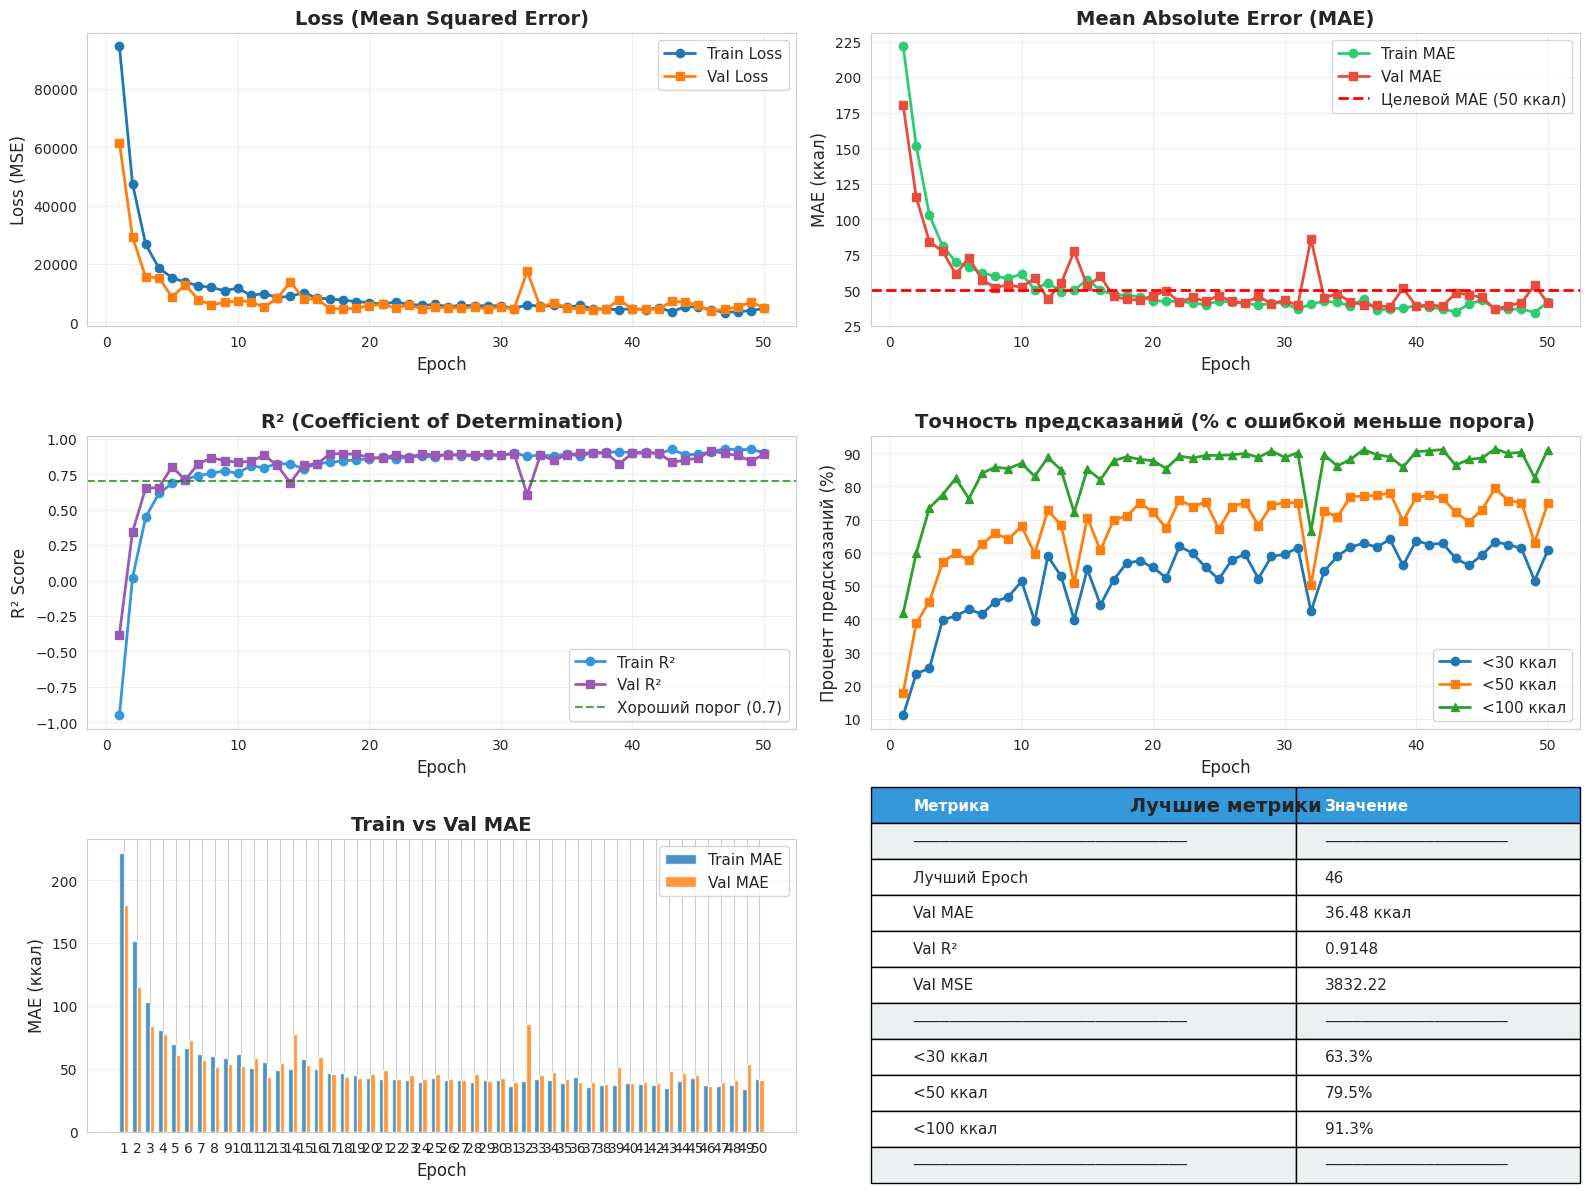


Визуализация сохранена: /home/ubuntu/multimodal_calorie_count/logs/training_visualization.png


In [41]:
# Визуализация обучения

# Загрузка истории обучения
history_df = pd.read_csv(os.path.join(cfg.LOG_PATH, 'training_history.csv'))

# Настройка стиля
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# 1. Loss (MSE)
axes[0, 0].plot(history_df['epoch'], history_df['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0, 0].set_title('Loss (Mean Squared Error)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. MAE (главная метрика)
axes[0, 1].plot(history_df['epoch'], history_df['train_mae'], label='Train MAE', marker='o', linewidth=2, color='#2ecc71')
axes[0, 1].plot(history_df['epoch'], history_df['val_mae'], label='Val MAE', marker='s', linewidth=2, color='#e74c3c')
axes[0, 1].axhline(y=50, color='red', linestyle='--', linewidth=2, label='Целевой MAE (50 ккал)')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('MAE (ккал)', fontsize=12)
axes[0, 1].set_title('Mean Absolute Error (MAE)', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. R² Score
axes[1, 0].plot(history_df['epoch'], history_df['train_r2'], label='Train R²', marker='o', linewidth=2, color='#3498db')
axes[1, 0].plot(history_df['epoch'], history_df['val_r2'], label='Val R²', marker='s', linewidth=2, color='#9b59b6')
axes[1, 0].axhline(y=0.7, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Хороший порог (0.7)')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('R² Score', fontsize=12)
axes[1, 0].set_title('R² (Coefficient of Determination)', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# 4. Percentile Metrics
axes[1, 1].plot(history_df['epoch'], history_df['val_mae_under_30'], label='<30 ккал', marker='o', linewidth=2)
axes[1, 1].plot(history_df['epoch'], history_df['val_mae_under_50'], label='<50 ккал', marker='s', linewidth=2)
axes[1, 1].plot(history_df['epoch'], history_df['val_mae_under_100'], label='<100 ккал', marker='^', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Процент предсказаний (%)', fontsize=12)
axes[1, 1].set_title('Точность предсказаний (% с ошибкой меньше порога)', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

# 5. Train vs Val MAE (сравнение)
epochs = history_df['epoch']
x = range(len(epochs))
width = 0.35
axes[2, 0].bar([i - width/2 for i in x], history_df['train_mae'], width, label='Train MAE', alpha=0.8)
axes[2, 0].bar([i + width/2 for i in x], history_df['val_mae'], width, label='Val MAE', alpha=0.8)
axes[2, 0].set_xlabel('Epoch', fontsize=12)
axes[2, 0].set_ylabel('MAE (ккал)', fontsize=12)
axes[2, 0].set_title('Train vs Val MAE', fontsize=14, fontweight='bold')
axes[2, 0].set_xticks(x)
axes[2, 0].set_xticklabels(epochs)
axes[2, 0].legend(fontsize=11)
axes[2, 0].grid(True, alpha=0.3, axis='y')

# 6. Итоговая таблица с метриками
best_epoch = history_df.loc[history_df['val_mae'].idxmin()]
axes[2, 1].axis('off')
table_data = [
    ['Метрика', 'Значение'],
    ['─' * 30, '─' * 20],
    ['Лучший Epoch', f"{int(best_epoch['epoch'])}"],
    ['Val MAE', f"{best_epoch['val_mae']:.2f} ккал"],
    ['Val R²', f"{best_epoch['val_r2']:.4f}"],
    ['Val MSE', f"{best_epoch['val_mse']:.2f}"],
    ['─' * 30, '─' * 20],
    ['<30 ккал', f"{best_epoch['val_mae_under_30']:.1f}%"],
    ['<50 ккал', f"{best_epoch['val_mae_under_50']:.1f}%"],
    ['<100 ккал', f"{best_epoch['val_mae_under_100']:.1f}%"],
    ['─' * 30, '─' * 20]
]

table = axes[2, 1].table(cellText=table_data, cellLoc='left', loc='center',
                         colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Стилизация заголовка таблицы
for i in range(2):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Стилизация разделителей
for row in [1, 6, 10]:
    for col in range(2):
        table[(row, col)].set_facecolor('#ecf0f1')

axes[2, 1].set_title('Лучшие метрики', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(cfg.LOG_PATH, 'training_visualization.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nВизуализация сохранена: {os.path.join(cfg.LOG_PATH, 'training_visualization.png')}")

Попробуем заменить первую часть на трансформер.

In [42]:
# Конфигурация с версионированием (PATHS не трогаем)

def seed_everything(seed: int):
    """Установка seed для воспроизводимости"""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def set_requires_grad(module: nn.Module, unfreeze_pattern="", verbose=False):
    """Заморозка/разморозка слоёв по паттерну"""
    if len(unfreeze_pattern) == 0:
        for _, param in module.named_parameters():
            param.requires_grad = False
        return
    
    pattern = unfreeze_pattern.split("|")
    for name, param in module.named_parameters():
        if any([name.startswith(p) for p in pattern]):
            param.requires_grad = True
            if verbose:
                print(f"Разморожен слой: {name}")
        else:
            param.requires_grad = False

class Config:
    # Seed
    SEED = 42
    
    # Версия модели 
    MODEL_VERSION = "vit_base"  
    
    # Модели
    TEXT_MODEL_NAME = "bert-base-uncased"
    IMAGE_MODEL_NAME = "vit_base_patch16_224"  # Vision Transformer (ViT-B/16)
    
    # Заморозка слоёв
    TEXT_MODEL_UNFREEZE = "encoder.layer.10|encoder.layer.11|pooler"
    IMAGE_MODEL_UNFREEZE = "blocks.10|blocks.11|norm|head"
    
    # Гиперпараметры
    BATCH_SIZE = 32
    TEXT_LR = 3e-5
    IMAGE_LR = 1e-4
    REGRESSOR_LR = 1e-3
    EPOCHS = 50
    DROPOUT = 0.3
    HIDDEN_DIM = 512
    
    # Пути 
    PROCESSED_DATA_PATH = PATHS['processed_dish']
    IMAGES_DIR = PATHS['images_dir']
    
    # Версионированные пути для сохранения
    SAVE_PATH = os.path.join(PATHS['models_dir'], f'best_model_{MODEL_VERSION}.pth')
    CHECKPOINT_PATH = os.path.join(PATHS['models_dir'], f'checkpoint_{MODEL_VERSION}.pth')
    LOG_PATH = os.path.join(PATHS['logs_dir'], MODEL_VERSION)
    
    # Ранняя остановка
    PATIENCE = 10
    MIN_DELTA = 1.0

# Инициализация
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cfg = Config()
seed_everything(cfg.SEED)

# Создание папки для логов
os.makedirs(cfg.LOG_PATH, exist_ok=True)

print(f"Seed установлен: {cfg.SEED}")
print(f"Устройство: {device}")
print(f"Model version: {cfg.MODEL_VERSION}")
print(f"Text model: {cfg.TEXT_MODEL_NAME}")
print(f"Image model: {cfg.IMAGE_MODEL_NAME}")
print(f"Save path: {cfg.SAVE_PATH}")
print(f"Log path: {cfg.LOG_PATH}")

Seed установлен: 42
Устройство: cuda
Model version: vit_base
Text model: bert-base-uncased
Image model: vit_base_patch16_224
Save path: /home/ubuntu/multimodal_calorie_count/models/best_model_vit_base.pth
Log path: /home/ubuntu/multimodal_calorie_count/logs/vit_base


In [43]:
history = train(cfg, device)


ИНИЦИАЛИЗАЦИЯ МОДЕЛИ



Настройка заморозки слоёв...
Разморожен слой: encoder.layer.10.attention.self.query.weight
Разморожен слой: encoder.layer.10.attention.self.query.bias
Разморожен слой: encoder.layer.10.attention.self.key.weight
Разморожен слой: encoder.layer.10.attention.self.key.bias
Разморожен слой: encoder.layer.10.attention.self.value.weight
Разморожен слой: encoder.layer.10.attention.self.value.bias
Разморожен слой: encoder.layer.10.attention.output.dense.weight
Разморожен слой: encoder.layer.10.attention.output.dense.bias
Разморожен слой: encoder.layer.10.attention.output.LayerNorm.weight
Разморожен слой: encoder.layer.10.attention.output.LayerNorm.bias
Разморожен слой: encoder.layer.10.intermediate.dense.weight
Разморожен слой: encoder.layer.10.intermediate.dense.bias
Разморожен слой: encoder.layer.10.output.dense.weight
Разморожен слой: encoder.layer.10.output.dense.bias
Разморожен слой: encoder.layer.10.output.LayerNorm.weight
Разморожен слой: encoder.layer.10.output.LayerNorm.bias
Разморожен 

Epoch 1/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 1/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 92951.0010 | MAE: 217.73 ккал | MSE: 92961.91 | R²: -0.9040
Val   | Loss: 57340.3126 | MAE: 176.13 ккал | MSE: 57763.11 | R²: -0.2848
Val   | <30 ккал: 9.3% | <50 ккал: 16.0% | <100 ккал: 38.1%
Лучшая модель сохранена (MAE: 176.13 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 2/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 2/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 43152.8373 | MAE: 141.78 ккал | MSE: 43577.48 | R²: 0.1075
Val   | Loss: 23251.7153 | MAE: 96.03 ккал | MSE: 23433.70 | R²: 0.4788
Val   | <30 ккал: 32.9% | <50 ккал: 50.1% | <100 ккал: 69.8%
Лучшая модель сохранена (MAE: 96.03 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 3/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 3/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 23908.3704 | MAE: 92.82 ккал | MSE: 24145.87 | R²: 0.5055
Val   | Loss: 17338.2879 | MAE: 82.03 ккал | MSE: 17465.76 | R²: 0.6115
Val   | <30 ккал: 44.0% | <50 ккал: 57.2% | <100 ккал: 71.8%
Лучшая модель сохранена (MAE: 82.03 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 4/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 4/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 17719.4641 | MAE: 76.67 ккал | MSE: 17792.59 | R²: 0.6356
Val   | Loss: 9959.8161 | MAE: 67.77 ккал | MSE: 9992.46 | R²: 0.7777
Val   | <30 ккал: 39.3% | <50 ккал: 55.4% | <100 ккал: 76.9%
Лучшая модель сохранена (MAE: 67.77 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 5/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 5/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 14041.2053 | MAE: 67.01 ккал | MSE: 14188.20 | R²: 0.7094
Val   | Loss: 8086.8823 | MAE: 59.06 ккал | MSE: 8119.53 | R²: 0.8194
Val   | <30 ккал: 47.1% | <50 ккал: 62.9% | <100 ккал: 80.5%
Лучшая модель сохранена (MAE: 59.06 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 6/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 6/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 13375.9300 | MAE: 63.44 ккал | MSE: 13469.19 | R²: 0.7241
Val   | Loss: 10723.0379 | MAE: 64.21 ккал | MSE: 10799.15 | R²: 0.7598
Val   | <30 ккал: 47.5% | <50 ккал: 62.9% | <100 ккал: 80.5%
Patience: 1/10
────────────────────────────────────────────────────────────────────────────────



Epoch 7/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 7/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 10784.1614 | MAE: 56.19 ккал | MSE: 10889.72 | R²: 0.7770
Val   | Loss: 6647.3731 | MAE: 51.37 ккал | MSE: 6684.77 | R²: 0.8513
Val   | <30 ккал: 51.7% | <50 ккал: 69.4% | <100 ккал: 85.8%
Лучшая модель сохранена (MAE: 51.37 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 8/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 8/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 48722.7356 | MAE: 56.21 ккал | MSE: 10911.42 | R²: 0.7765
Val   | Loss: 13432.6058 | MAE: 76.71 ккал | MSE: 13397.73 | R²: 0.7020
Val   | <30 ккал: 44.2% | <50 ккал: 55.2% | <100 ккал: 71.4%
Patience: 1/10
────────────────────────────────────────────────────────────────────────────────



Epoch 9/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 9/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 20070.3740 | MAE: 87.04 ккал | MSE: 20055.85 | R²: 0.5892
Val   | Loss: 15945.0851 | MAE: 79.83 ккал | MSE: 16058.29 | R²: 0.6428
Val   | <30 ккал: 44.4% | <50 ккал: 57.2% | <100 ккал: 73.4%
Patience: 2/10
────────────────────────────────────────────────────────────────────────────────



Epoch 10/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 10/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 12551.0668 | MAE: 63.27 ккал | MSE: 12583.25 | R²: 0.7423
Val   | Loss: 9086.0313 | MAE: 59.68 ккал | MSE: 9135.98 | R²: 0.7968
Val   | <30 ккал: 47.1% | <50 ккал: 63.3% | <100 ккал: 81.9%
Patience: 3/10
────────────────────────────────────────────────────────────────────────────────



Epoch 11/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 11/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 11202.4793 | MAE: 57.78 ккал | MSE: 11310.28 | R²: 0.7683
Val   | Loss: 9557.2731 | MAE: 62.32 ккал | MSE: 9623.38 | R²: 0.7859
Val   | <30 ккал: 51.1% | <50 ккал: 61.7% | <100 ккал: 80.5%
Patience: 4/10
────────────────────────────────────────────────────────────────────────────────



Epoch 12/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 12/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 9207.1861 | MAE: 51.17 ккал | MSE: 9281.24 | R²: 0.8099
Val   | Loss: 6204.1028 | MAE: 52.05 ккал | MSE: 6215.46 | R²: 0.8617
Val   | <30 ккал: 53.3% | <50 ккал: 64.7% | <100 ккал: 82.6%
Patience: 5/10
────────────────────────────────────────────────────────────────────────────────



Epoch 13/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 13/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 8822.2885 | MAE: 49.94 ккал | MSE: 8912.70 | R²: 0.8175
Val   | Loss: 7431.9750 | MAE: 52.84 ккал | MSE: 7479.82 | R²: 0.8336
Val   | <30 ккал: 52.7% | <50 ккал: 67.9% | <100 ккал: 84.8%
Patience: 6/10
────────────────────────────────────────────────────────────────────────────────



Epoch 14/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 14/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 9500.1928 | MAE: 50.15 ккал | MSE: 9495.38 | R²: 0.8055
Val   | Loss: 5971.4279 | MAE: 49.56 ккал | MSE: 6002.33 | R²: 0.8665
Val   | <30 ккал: 54.8% | <50 ккал: 70.8% | <100 ккал: 85.6%
Лучшая модель сохранена (MAE: 49.56 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 15/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.17it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 15/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 8250.8069 | MAE: 48.77 ккал | MSE: 8313.18 | R²: 0.8297
Val   | Loss: 7472.6356 | MAE: 53.65 ккал | MSE: 7518.98 | R²: 0.8328
Val   | <30 ккал: 53.8% | <50 ккал: 66.1% | <100 ккал: 82.1%
Patience: 1/10
────────────────────────────────────────────────────────────────────────────────



Epoch 16/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 16/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 8100.2582 | MAE: 46.38 ккал | MSE: 8081.53 | R²: 0.8345
Val   | Loss: 6846.5025 | MAE: 50.79 ккал | MSE: 6861.73 | R²: 0.8474
Val   | <30 ккал: 54.0% | <50 ккал: 69.6% | <100 ккал: 83.8%
Patience: 2/10
────────────────────────────────────────────────────────────────────────────────



Epoch 17/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 17/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 7134.9204 | MAE: 44.25 ккал | MSE: 7209.11 | R²: 0.8523
Val   | Loss: 9018.7098 | MAE: 57.27 ккал | MSE: 9071.97 | R²: 0.7982
Val   | <30 ккал: 52.5% | <50 ккал: 64.7% | <100 ккал: 80.9%
Patience: 3/10
────────────────────────────────────────────────────────────────────────────────



Epoch 18/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 18/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 6989.8913 | MAE: 44.83 ккал | MSE: 7031.50 | R²: 0.8560
Val   | Loss: 5716.0686 | MAE: 46.57 ккал | MSE: 5727.19 | R²: 0.8726
Val   | <30 ккал: 57.4% | <50 ккал: 70.2% | <100 ккал: 86.8%
Лучшая модель сохранена (MAE: 46.57 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 19/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 19/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 6825.2597 | MAE: 43.75 ккал | MSE: 6895.01 | R²: 0.8588
Val   | Loss: 6318.8633 | MAE: 48.35 ккал | MSE: 6348.55 | R²: 0.8588
Val   | <30 ккал: 57.0% | <50 ккал: 71.6% | <100 ккал: 86.2%
Patience: 1/10
────────────────────────────────────────────────────────────────────────────────



Epoch 20/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 20/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 6715.1643 | MAE: 41.68 ккал | MSE: 6778.26 | R²: 0.8612
Val   | Loss: 6086.8944 | MAE: 47.40 ккал | MSE: 6091.32 | R²: 0.8645
Val   | <30 ккал: 56.6% | <50 ккал: 70.6% | <100 ккал: 84.2%
Patience: 2/10
────────────────────────────────────────────────────────────────────────────────



Epoch 21/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 21/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 6560.1669 | MAE: 41.75 ккал | MSE: 6489.67 | R²: 0.8671
Val   | Loss: 6923.3864 | MAE: 49.92 ккал | MSE: 6957.89 | R²: 0.8452
Val   | <30 ккал: 56.0% | <50 ккал: 70.2% | <100 ккал: 85.0%
Patience: 3/10
────────────────────────────────────────────────────────────────────────────────



Epoch 22/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 22/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 6123.6564 | MAE: 40.36 ккал | MSE: 6183.05 | R²: 0.8734
Val   | Loss: 5591.0968 | MAE: 45.31 ккал | MSE: 5619.64 | R²: 0.8750
Val   | <30 ккал: 57.8% | <50 ккал: 71.6% | <100 ккал: 87.8%
Лучшая модель сохранена (MAE: 45.31 ккал)
────────────────────────────────────────────────────────────────────────────────



Epoch 23/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 23/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5775.4575 | MAE: 38.24 ккал | MSE: 5814.31 | R²: 0.8809
Val   | Loss: 6947.5552 | MAE: 50.01 ккал | MSE: 6990.90 | R²: 0.8445
Val   | <30 ккал: 56.6% | <50 ккал: 70.4% | <100 ккал: 86.2%
Patience: 1/10
────────────────────────────────────────────────────────────────────────────────



Epoch 24/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 24/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5617.8826 | MAE: 39.08 ккал | MSE: 5676.16 | R²: 0.8837
Val   | Loss: 5579.1078 | MAE: 46.61 ккал | MSE: 5593.71 | R²: 0.8756
Val   | <30 ккал: 56.4% | <50 ккал: 69.6% | <100 ккал: 87.4%
Patience: 2/10
────────────────────────────────────────────────────────────────────────────────



Epoch 25/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 25/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5704.4248 | MAE: 38.49 ккал | MSE: 5622.99 | R²: 0.8848
Val   | Loss: 5333.2767 | MAE: 45.27 ккал | MSE: 5345.38 | R²: 0.8811
Val   | <30 ккал: 58.0% | <50 ккал: 72.2% | <100 ккал: 87.0%
Patience: 3/10
────────────────────────────────────────────────────────────────────────────────



Epoch 26/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 26/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5308.9584 | MAE: 37.35 ккал | MSE: 5362.63 | R²: 0.8902
Val   | Loss: 6502.8612 | MAE: 46.50 ккал | MSE: 6549.18 | R²: 0.8543
Val   | <30 ккал: 60.6% | <50 ккал: 73.8% | <100 ккал: 86.8%
Patience: 4/10
────────────────────────────────────────────────────────────────────────────────



Epoch 27/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.19it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 27/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5639.9354 | MAE: 37.77 ккал | MSE: 5693.16 | R²: 0.8834
Val   | Loss: 5719.4407 | MAE: 48.17 ккал | MSE: 5745.53 | R²: 0.8722
Val   | <30 ккал: 51.5% | <50 ккал: 68.4% | <100 ккал: 87.0%
Patience: 5/10
────────────────────────────────────────────────────────────────────────────────



Epoch 28/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 28/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 4959.1792 | MAE: 35.78 ккал | MSE: 5010.58 | R²: 0.8974
Val   | Loss: 4593.1376 | MAE: 45.77 ккал | MSE: 4603.66 | R²: 0.8976
Val   | <30 ккал: 51.5% | <50 ккал: 68.8% | <100 ккал: 87.6%
Patience: 6/10
────────────────────────────────────────────────────────────────────────────────



Epoch 29/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 29/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 4878.4896 | MAE: 34.87 ккал | MSE: 4908.97 | R²: 0.8995
Val   | Loss: 7620.5403 | MAE: 54.54 ккал | MSE: 7671.23 | R²: 0.8294
Val   | <30 ккал: 52.7% | <50 ккал: 66.9% | <100 ккал: 83.4%
Patience: 7/10
────────────────────────────────────────────────────────────────────────────────



Epoch 30/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 30/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 6663.7519 | MAE: 43.56 ккал | MSE: 6674.04 | R²: 0.8633
Val   | Loss: 6364.1425 | MAE: 49.67 ккал | MSE: 6382.51 | R²: 0.8580
Val   | <30 ккал: 54.0% | <50 ккал: 68.0% | <100 ккал: 86.4%
Patience: 8/10
────────────────────────────────────────────────────────────────────────────────



Epoch 31/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]



────────────────────────────────────────────────────────────────────────────────
Epoch 31/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5264.6287 | MAE: 38.29 ккал | MSE: 5305.52 | R²: 0.8913
Val   | Loss: 5861.6502 | MAE: 45.30 ккал | MSE: 5858.38 | R²: 0.8697
Val   | <30 ккал: 60.0% | <50 ккал: 73.0% | <100 ккал: 85.8%
Patience: 9/10
────────────────────────────────────────────────────────────────────────────────



Epoch 32/50 [Val]: 100%|██████████| 16/16 [00:13<00:00,  1.18it/s]


────────────────────────────────────────────────────────────────────────────────
Epoch 32/50
────────────────────────────────────────────────────────────────────────────────
Train | Loss: 5270.8462 | MAE: 39.59 ккал | MSE: 5256.12 | R²: 0.8923
Val   | Loss: 6543.3560 | MAE: 48.94 ккал | MSE: 6578.85 | R²: 0.8537
Val   | <30 ккал: 55.8% | <50 ккал: 70.2% | <100 ккал: 86.4%
Patience: 10/10

⚠ Ранняя остановка на epoch 32

ОБУЧЕНИЕ ЗАВЕРШЕНО
История обучения сохранена: /home/ubuntu/multimodal_calorie_count/logs/vit_base/training_history.csv
Лучший результат - Val MAE: 45.31 ккал



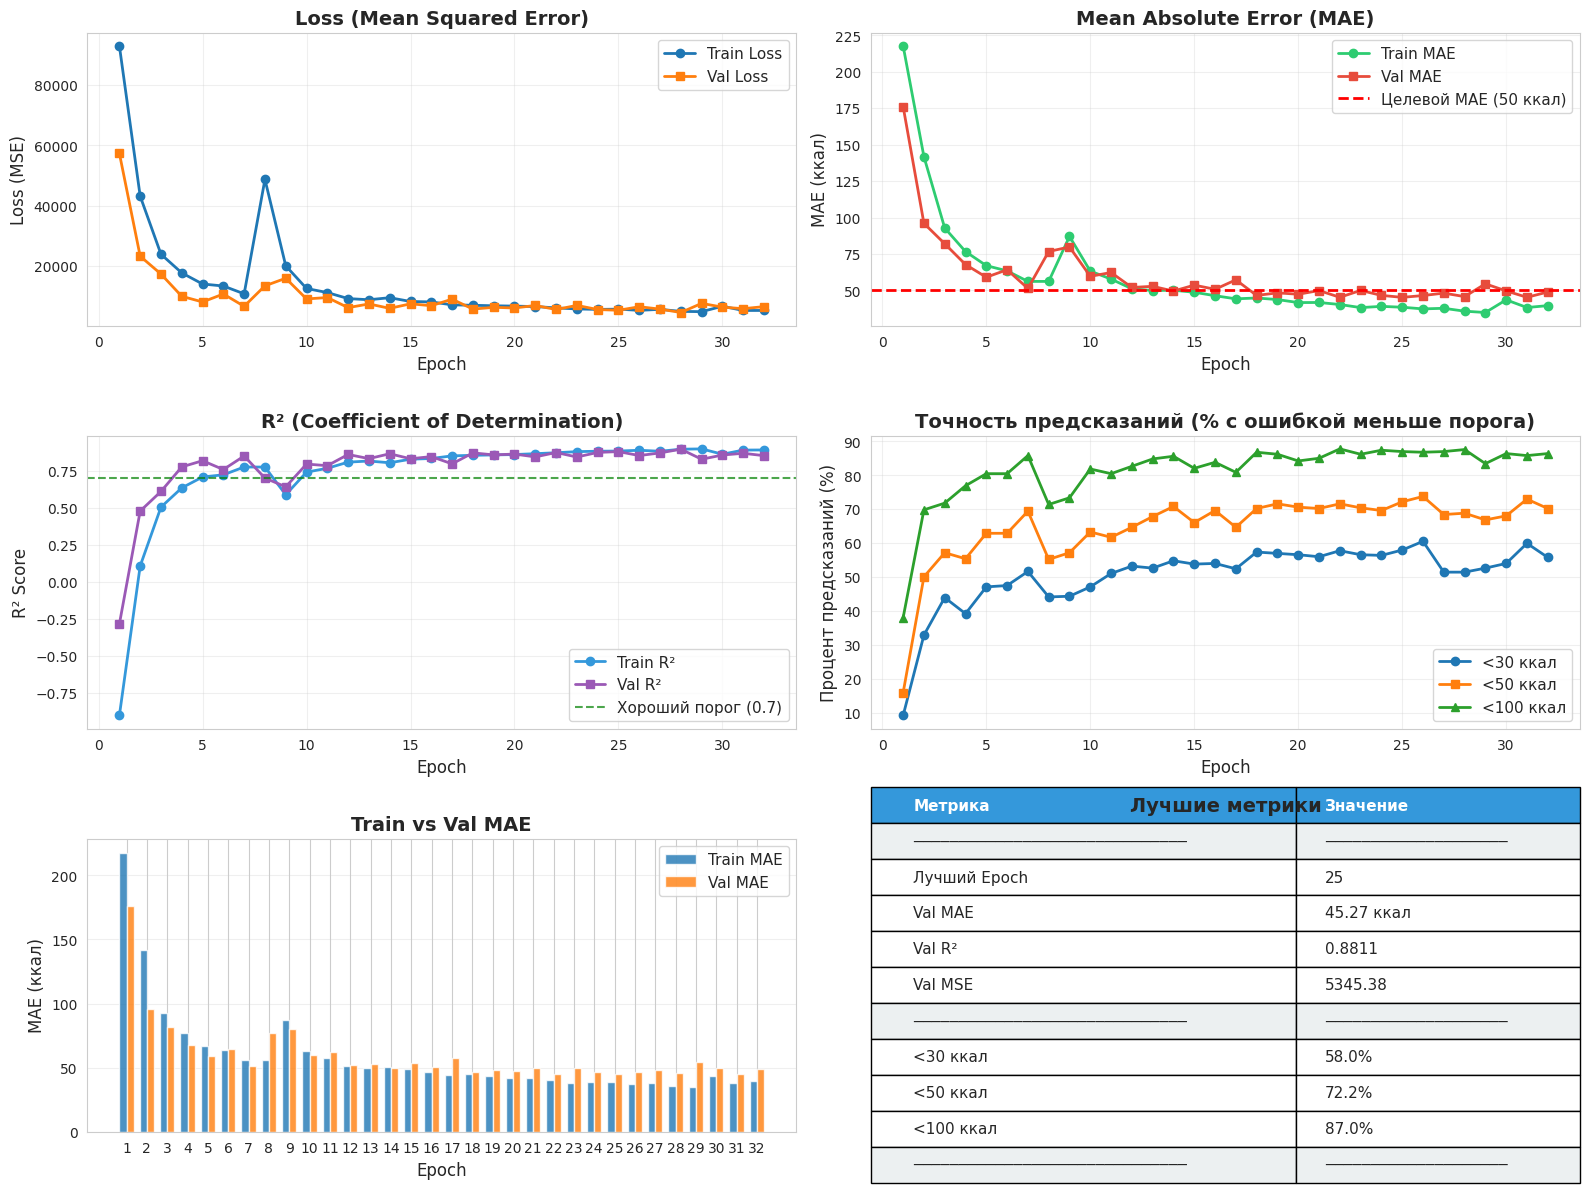


Визуализация сохранена: /home/ubuntu/multimodal_calorie_count/logs/vit_base/training_visualization.png


In [44]:
# Визуализация обучения

# Загрузка истории обучения
history_df = pd.read_csv(os.path.join(cfg.LOG_PATH, 'training_history.csv'))

# Настройка стиля
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# 1. Loss (MSE)
axes[0, 0].plot(history_df['epoch'], history_df['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0, 0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0, 0].set_title('Loss (Mean Squared Error)', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2. MAE (главная метрика)
axes[0, 1].plot(history_df['epoch'], history_df['train_mae'], label='Train MAE', marker='o', linewidth=2, color='#2ecc71')
axes[0, 1].plot(history_df['epoch'], history_df['val_mae'], label='Val MAE', marker='s', linewidth=2, color='#e74c3c')
axes[0, 1].axhline(y=50, color='red', linestyle='--', linewidth=2, label='Целевой MAE (50 ккал)')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('MAE (ккал)', fontsize=12)
axes[0, 1].set_title('Mean Absolute Error (MAE)', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 3. R² Score
axes[1, 0].plot(history_df['epoch'], history_df['train_r2'], label='Train R²', marker='o', linewidth=2, color='#3498db')
axes[1, 0].plot(history_df['epoch'], history_df['val_r2'], label='Val R²', marker='s', linewidth=2, color='#9b59b6')
axes[1, 0].axhline(y=0.7, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Хороший порог (0.7)')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('R² Score', fontsize=12)
axes[1, 0].set_title('R² (Coefficient of Determination)', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# 4. Percentile Metrics
axes[1, 1].plot(history_df['epoch'], history_df['val_mae_under_30'], label='<30 ккал', marker='o', linewidth=2)
axes[1, 1].plot(history_df['epoch'], history_df['val_mae_under_50'], label='<50 ккал', marker='s', linewidth=2)
axes[1, 1].plot(history_df['epoch'], history_df['val_mae_under_100'], label='<100 ккал', marker='^', linewidth=2)
axes[1, 1].set_xlabel('Epoch', fontsize=12)
axes[1, 1].set_ylabel('Процент предсказаний (%)', fontsize=12)
axes[1, 1].set_title('Точность предсказаний (% с ошибкой меньше порога)', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

# 5. Train vs Val MAE (сравнение)
epochs = history_df['epoch']
x = range(len(epochs))
width = 0.35
axes[2, 0].bar([i - width/2 for i in x], history_df['train_mae'], width, label='Train MAE', alpha=0.8)
axes[2, 0].bar([i + width/2 for i in x], history_df['val_mae'], width, label='Val MAE', alpha=0.8)
axes[2, 0].set_xlabel('Epoch', fontsize=12)
axes[2, 0].set_ylabel('MAE (ккал)', fontsize=12)
axes[2, 0].set_title('Train vs Val MAE', fontsize=14, fontweight='bold')
axes[2, 0].set_xticks(x)
axes[2, 0].set_xticklabels(epochs)
axes[2, 0].legend(fontsize=11)
axes[2, 0].grid(True, alpha=0.3, axis='y')

# 6. Итоговая таблица с метриками
best_epoch = history_df.loc[history_df['val_mae'].idxmin()]
axes[2, 1].axis('off')
table_data = [
    ['Метрика', 'Значение'],
    ['─' * 30, '─' * 20],
    ['Лучший Epoch', f"{int(best_epoch['epoch'])}"],
    ['Val MAE', f"{best_epoch['val_mae']:.2f} ккал"],
    ['Val R²', f"{best_epoch['val_r2']:.4f}"],
    ['Val MSE', f"{best_epoch['val_mse']:.2f}"],
    ['─' * 30, '─' * 20],
    ['<30 ккал', f"{best_epoch['val_mae_under_30']:.1f}%"],
    ['<50 ккал', f"{best_epoch['val_mae_under_50']:.1f}%"],
    ['<100 ккал', f"{best_epoch['val_mae_under_100']:.1f}%"],
    ['─' * 30, '─' * 20]
]

table = axes[2, 1].table(cellText=table_data, cellLoc='left', loc='center',
                         colWidths=[0.6, 0.4])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Стилизация заголовка таблицы
for i in range(2):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Стилизация разделителей
for row in [1, 6, 10]:
    for col in range(2):
        table[(row, col)].set_facecolor('#ecf0f1')

axes[2, 1].set_title('Лучшие метрики', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(cfg.LOG_PATH, 'training_visualization.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\nВизуализация сохранена: {os.path.join(cfg.LOG_PATH, 'training_visualization.png')}")

In [50]:
# Переопределение модели с EfficientNet-B7 и загрузка весов, так как она оказалась лучше


# Архитектура модели (EfficientNet-B7)
class CalorieEstimationModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        # Text encoder (BERT)
        self.text_model = AutoModel.from_pretrained(config.TEXT_MODEL_NAME)
        
        # Image encoder (EfficientNet-B7)
        self.image_model = timm.create_model(
            config.IMAGE_MODEL_NAME,
            pretrained=True,
            num_classes=0
        )
        
        # Projection layers
        self.text_proj = nn.Linear(self.text_model.config.hidden_size, config.HIDDEN_DIM)
        self.image_proj = nn.Linear(self.image_model.num_features, config.HIDDEN_DIM)
        self.mass_proj = nn.Linear(1, config.HIDDEN_DIM)
        
        # Regression head
        self.regressor = nn.Sequential(
            nn.Linear(config.HIDDEN_DIM, config.HIDDEN_DIM // 2),
            nn.LayerNorm(config.HIDDEN_DIM // 2),
            nn.ReLU(),
            nn.Dropout(config.DROPOUT),
            nn.Linear(config.HIDDEN_DIM // 2, config.HIDDEN_DIM // 4),
            nn.ReLU(),
            nn.Dropout(config.DROPOUT / 2),
            nn.Linear(config.HIDDEN_DIM // 4, 1),
            nn.ReLU()
        )
        
    def forward(self, image, ingredients, mass):
        # Эмбеддинги
        text_features = self.text_model(**ingredients).last_hidden_state[:, 0, :]
        image_features = self.image_model(image)
        
        # Проекция
        text_emb = self.text_proj(text_features)
        image_emb = self.image_proj(image_features)
        mass_emb = self.mass_proj(mass)
        
        # Early fusion
        fused_emb = text_emb * image_emb * mass_emb
        
        # Предсказание
        calories = self.regressor(fused_emb)
        return calories

# Конфигурация (убедитесь что IMAGE_MODEL_NAME = tf_efficientnet_b7)
cfg.IMAGE_MODEL_NAME = "tf_efficientnet_b7"

# Загрузка модели с весами
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CalorieEstimationModel(cfg).to(device)

checkpoint = torch.load('/home/ubuntu/multimodal_calorie_count/models/best_calorie_model.pth', 
                       map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Модель загружена успешно!")
print(f"Val MAE из обучения: {checkpoint['val_mae']:.2f} ккал")
print(f"Image model: {cfg.IMAGE_MODEL_NAME}")
print(f"EfficientNet output dim: {model.image_model.num_features}")

Модель загружена успешно!
Val MAE из обучения: 36.48 ккал
Image model: tf_efficientnet_b7
EfficientNet output dim: 2560


In [51]:
# Ablation Study - Анализ вклада каждой модальности


class AblationCalorieDataset(CalorieDataset):
    """Dataset с возможностью маскирования модальностей"""
    def __init__(self, dataframe, images_dir, config, tokenizer, transform=None, mask_mode=None):
        super().__init__(dataframe, images_dir, config, tokenizer, transform)
        self.mask_mode = mask_mode  # None, 'image', 'text', 'mass'
        
    def __getitem__(self, idx):
        item = super().__getitem__(idx)
        
        # Маскирование модальностей
        if self.mask_mode == 'image':
            # Заменяем изображение на случайный шум
            item['image'] = torch.randn_like(item['image'])
        elif self.mask_mode == 'text':
            # Заменяем текст на пустой (padding tokens)
            item['input_ids'] = torch.zeros_like(item['input_ids'])
            item['attention_mask'] = torch.zeros_like(item['attention_mask'])
        elif self.mask_mode == 'mass':
            # Заменяем массу на среднее значение по датасету
            item['mass'] = torch.tensor(300.0, dtype=torch.float32)  # примерное среднее
        
        return item


def validate_ablation(model, test_loader, device, mask_mode=None):
    """
    Валидация модели с маскированием определенной модальности
    
    Args:
        model: обученная модель
        test_loader: DataLoader для тестовых данных
        device: устройство
        mask_mode: какую модальность маскировать (None, 'image', 'text', 'mass')
    
    Returns:
        mae, r2: метрики качества
    """
    model.eval()
    val_preds = []
    val_targets = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f"Ablation: mask={mask_mode}"):
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            mass = batch['mass'].to(device).unsqueeze(1)
            calories = batch['calories'].to(device).unsqueeze(1)
            
            ingredients = {
                'input_ids': input_ids,
                'attention_mask': attention_mask
            }
            
            predictions = model(images, ingredients, mass)
            
            val_preds.extend(predictions.cpu().numpy().flatten())
            val_targets.extend(calories.cpu().numpy().flatten())
    
    mae = mean_absolute_error(val_targets, val_preds)
    r2 = r2_score(val_targets, val_preds)
    
    return mae, r2


# Загрузка лучшей модели (EfficientNet)
print("="*80)
print("ABLATION STUDY - Анализ вклада модальностей")
print("="*80)

# Конфигурация для EfficientNet модели
class AblationConfig:
    SEED = 42
    TEXT_MODEL_NAME = "bert-base-uncased"
    IMAGE_MODEL_NAME = "tf_efficientnet_b7"
    MODEL_VERSION = "efficientnet_b7"
    BATCH_SIZE = 32
    DROPOUT = 0.3
    HIDDEN_DIM = 512
    IMAGES_DIR = PATHS['images_dir']

ablation_cfg = AblationConfig()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Загрузка обученной модели
model = CalorieEstimationModel(ablation_cfg).to(device)
checkpoint = torch.load(os.path.join(PATHS['models_dir'], 'best_calorie_model.pth'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Модель загружена: best_calorie_model.pth")
print(f"Лучший Val MAE из обучения: {checkpoint['val_mae']:.2f} ккал\n")

print(f"Модель загружена: {ablation_cfg.MODEL_VERSION}")
print(f"Лучший Val MAE из обучения: {checkpoint['val_mae']:.2f} ккал\n")

# Токенизатор
tokenizer = AutoTokenizer.from_pretrained(ablation_cfg.TEXT_MODEL_NAME)

# Тестовые трансформации (без аугментаций)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Тестовые данные
test_df = dish_dataset[dish_dataset['split'] == 'test'].copy()

print("-"*80)
print("ТЕСТИРОВАНИЕ С ПОЛНЫМИ ДАННЫМИ (baseline)")
print("-"*80)

# 1. Baseline - все модальности
test_dataset_full = AblationCalorieDataset(
    test_df, ablation_cfg.IMAGES_DIR, ablation_cfg, tokenizer, 
    transform=test_transform, mask_mode=None
)
test_loader_full = DataLoader(test_dataset_full, batch_size=ablation_cfg.BATCH_SIZE, shuffle=False, num_workers=0)
mae_full, r2_full = validate_ablation(model, test_loader_full, device, mask_mode=None)
print(f" Все модальности: MAE = {mae_full:.2f} ккал, R² = {r2_full:.4f}\n")

print("-"*80)
print("ТЕСТИРОВАНИЕ С МАСКИРОВАНИЕМ МОДАЛЬНОСТЕЙ")
print("-"*80)

# 2. Без изображений (только текст + масса)
test_dataset_no_image = AblationCalorieDataset(
    test_df, ablation_cfg.IMAGES_DIR, ablation_cfg, tokenizer, 
    transform=test_transform, mask_mode='image'
)
test_loader_no_image = DataLoader(test_dataset_no_image, batch_size=ablation_cfg.BATCH_SIZE, shuffle=False, num_workers=0)
mae_no_image, r2_no_image = validate_ablation(model, test_loader_no_image, device, mask_mode='image')
print(f"Без изображений (text + mass): MAE = {mae_no_image:.2f} ккал, R² = {r2_no_image:.4f}")

# 3. Без текста (только изображение + масса)
test_dataset_no_text = AblationCalorieDataset(
    test_df, ablation_cfg.IMAGES_DIR, ablation_cfg, tokenizer, 
    transform=test_transform, mask_mode='text'
)
test_loader_no_text = DataLoader(test_dataset_no_text, batch_size=ablation_cfg.BATCH_SIZE, shuffle=False, num_workers=0)
mae_no_text, r2_no_text = validate_ablation(model, test_loader_no_text, device, mask_mode='text')
print(f"Без текста (image + mass): MAE = {mae_no_text:.2f} ккал, R² = {r2_no_text:.4f}")

# 4. Без массы (только изображение + текст)
test_dataset_no_mass = AblationCalorieDataset(
    test_df, ablation_cfg.IMAGES_DIR, ablation_cfg, tokenizer, 
    transform=test_transform, mask_mode='mass'
)
test_loader_no_mass = DataLoader(test_dataset_no_mass, batch_size=ablation_cfg.BATCH_SIZE, shuffle=False, num_workers=0)
mae_no_mass, r2_no_mass = validate_ablation(model, test_loader_no_mass, device, mask_mode='mass')
print(f"Без массы (image + text): MAE = {mae_no_mass:.2f} ккал, R² = {r2_no_mass:.4f}\n")

# Вычисление вклада каждой модальности
print("="*80)
print("ВКЛАД КАЖДОЙ МОДАЛЬНОСТИ (degradation при удалении)")
print("="*80)

image_contribution = mae_no_image - mae_full
text_contribution = mae_no_text - mae_full
mass_contribution = mae_no_mass - mae_full

print(f"Image contribution: +{image_contribution:.2f} ккал деградация без изображения")
print(f"Text contribution:  +{text_contribution:.2f} ккал деградация без текста")
print(f" Mass contribution:  +{mass_contribution:.2f} ккал деградация без массы")

# Итоговая таблица
results_df = pd.DataFrame({
    'Модальности': ['Все (baseline)', 'Text + Mass', 'Image + Mass', 'Image + Text'],
    'Замаскировано': ['—', 'Image', 'Text', 'Mass'],
    'MAE (ккал)': [mae_full, mae_no_image, mae_no_text, mae_no_mass],
    'R²': [r2_full, r2_no_image, r2_no_text, r2_no_mass],
    'Деградация MAE': [0, image_contribution, text_contribution, mass_contribution]
})

print("\n" + "="*80)
print("СВОДНАЯ ТАБЛИЦА")
print("="*80)
print(results_df.to_string(index=False))
print("="*80)


# Сохранение результатов
ablation_log_path = os.path.join(PATHS['logs_dir'], 'ablation_study.csv')
results_df.to_csv(ablation_log_path, index=False)
print(f"\nРезультаты ablation study сохранены: {ablation_log_path}")

ABLATION STUDY - Анализ вклада модальностей


/tmp/ipykernel_21763/300296612.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(PATHS['models_dir'], 'best_calorie_model.pth'))


Модель загружена: best_calorie_model.pth
Лучший Val MAE из обучения: 36.48 ккал

Модель загружена: efficientnet_b7
Лучший Val MAE из обучения: 36.48 ккал

--------------------------------------------------------------------------------
ТЕСТИРОВАНИЕ С ПОЛНЫМИ ДАННЫМИ (baseline)
--------------------------------------------------------------------------------
Проверка наличия изображений...
Все 507 изображений найдены


Ablation: mask=None: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]


 Все модальности: MAE = 36.48 ккал, R² = 0.9148

--------------------------------------------------------------------------------
ТЕСТИРОВАНИЕ С МАСКИРОВАНИЕМ МОДАЛЬНОСТЕЙ
--------------------------------------------------------------------------------
Проверка наличия изображений...
Все 507 изображений найдены


Ablation: mask=image: 100%|██████████| 16/16 [00:13<00:00,  1.22it/s]


Без изображений (text + mass): MAE = 73.52 ккал, R² = 0.7266
Проверка наличия изображений...
Все 507 изображений найдены


Ablation: mask=text: 100%|██████████| 16/16 [00:12<00:00,  1.26it/s]


Без текста (image + mass): MAE = 88.33 ккал, R² = 0.6400
Проверка наличия изображений...
Все 507 изображений найдены


Ablation: mask=mass: 100%|██████████| 16/16 [00:12<00:00,  1.25it/s]

Без массы (image + text): MAE = 165.25 ккал, R² = -0.1674

ВКЛАД КАЖДОЙ МОДАЛЬНОСТИ (degradation при удалении)
Image contribution: +37.04 ккал деградация без изображения
Text contribution:  +51.85 ккал деградация без текста
 Mass contribution:  +128.78 ккал деградация без массы

СВОДНАЯ ТАБЛИЦА
   Модальности Замаскировано  MAE (ккал)        R²  Деградация MAE
Все (baseline)             —   36.477243  0.914759        0.000000
   Text + Mass         Image   73.518116  0.726603       37.040874
  Image + Mass          Text   88.331359  0.639959       51.854116
  Image + Text          Mass  165.252964 -0.167394      128.775721

Результаты ablation study сохранены: /home/ubuntu/multimodal_calorie_count/logs/ablation_study.csv


In [ ]:
# Анализ примеров с ошибкой >100 ккал


# Подготовка данных
tokenizer = AutoTokenizer.from_pretrained(cfg.TEXT_MODEL_NAME)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_df = dish_dataset[dish_dataset['split'] == 'test'].copy()
test_dataset = CalorieDataset(test_df, cfg.IMAGES_DIR, cfg, tokenizer, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

# Получение предсказаний
results = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Анализ ошибок"):
        images = batch['image'].to(device)
        ingredients = {'input_ids': batch['input_ids'].to(device), 
                      'attention_mask': batch['attention_mask'].to(device)}
        mass = batch['mass'].to(device).unsqueeze(1)
        calories_true = batch['calories'].item()
        calories_pred = model(images, ingredients, mass).item()
        error = abs(calories_pred - calories_true)
        
        # Защита от деления на ноль
        rel_error = (error / calories_true * 100) if calories_true > 0 else 0
        
        results.append({
            'dish_id': batch['dish_id'][0],
            'true': calories_true,
            'pred': calories_pred,
            'error': error,
            'rel_error_%': rel_error
        })

# Анализ
results_df = pd.DataFrame(results)
results_df = results_df.merge(test_df[['dish_id', 'dish_description', 'total_mass']], on='dish_id')
big_errors = results_df[results_df['error'] > 100].sort_values('error', ascending=False)

# Статистика
print(f"\n{'='*80}")
print(f"Всего: {len(results_df)} | Ошибка >100: {len(big_errors)} ({len(big_errors)/len(results_df)*100:.1f}%)")
print(f"Средняя ошибка (>100): {big_errors['error'].mean():.2f} ккал | Макс: {big_errors['error'].max():.2f} ккал")
print(f"{'='*80}\n")

print("ТОП-10 ХУДШИХ:")
display(big_errors[['dish_id', 'dish_description', 'total_mass', 'true', 'pred', 'error']].head(10))

# Сохранение
big_errors.to_csv(os.path.join(PATHS['logs_dir'], 'big_errors_analysis.csv'), index=False)
print(f"\nРезультаты сохранены: {PATHS['logs_dir']}/big_errors_analysis.csv")

Проверка наличия изображений...
Все 507 изображений найдены


Анализ ошибок: 100%|██████████| 507/507 [00:20<00:00, 25.27it/s]


Всего: 507 | Ошибка >100: 44 (8.7%)
Средняя ошибка (>100): 170.81 ккал | Макс: 373.51 ккал

ТОП-10 ХУДШИХ:


dish_id                                   dish_description  \
298  dish_1558549806                 almonds; white rice; spinach (raw)   
171  dish_1558630325                       apple; garden salad; almonds   
76   dish_1566328831  pizza; cherry tomatoes; chicken; pineapple; ol...   
479  dish_1558375886                           almonds; sausage; grapes   
13   dish_1558720236                apple; carrot; cauliflower; almonds   
354  dish_1566414412  shallots; olive oil; garlic; lemon juice; basi...   
141  dish_1565811139  carrot; goat cheese; olive oil; broccoli; spin...   
311  dish_1562172643                egg whites; roasted potatoes; bacon   
173  dish_1559844366                          almonds; broccoli; grapes   
305  dish_1566414342  garlic; pepper; mushroom; oregano; cream; whea...   

     total_mass         true        pred       error  
298       203.0   781.958008  408.447845  373.510162  
171       269.0   751.541992  433.437775  318.104218  
76        500.0   941.609985  654.787170  286.822815  
479       277.0  1050.511108  771.372620  279.138489  
13        407.0   887.823059  609.495239  278.327820  
354       658.0   920.120422  671.930542  248.189880  
141       416.0   902.200012  683.910339  218.289673  
311       457.0   734.269958  521.120972  213.148987  
173       192.0   529.220032  319.205078  210.014954  
305       552.0   846.367065  639.258911  207.108154


✓ Результаты сохранены: /home/ubuntu/multimodal_calorie_count/logs/big_errors_analysis.csv


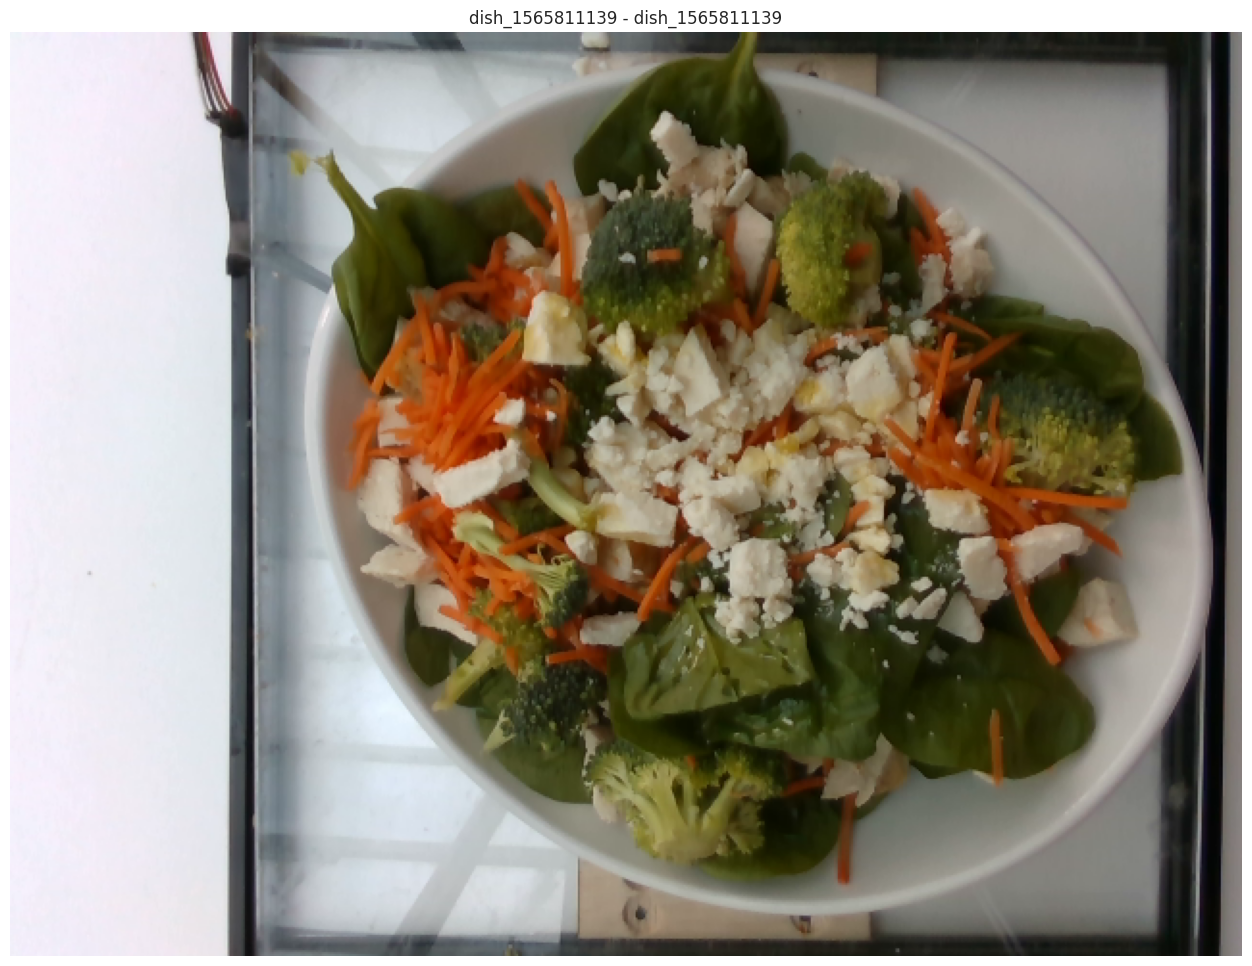

In [59]:
# Найти индекс изображения по имени файла
img_name = 'dish_1565811139'
for idx, (path, _) in enumerate(image_dataset.imgs):
    if img_name in path:
        img, label = image_dataset[idx]
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'{img_name} - {image_dataset.classes[label]}')
        plt.show()
        break

Получены удоволетворительные результаты при использовании мультимодального ИИ для определения калорийности блюда по списку ингредиентов. фото и массе блюда. Для выполнения задачи был взят BERT для текстового списка ингредиентов, tf_efficientnet_b7 для анализа фотографий (с агументациями). Были разморожены несколько верхних слоёв (у BERT предпоследний и последние слои в базе и слой для агрегации финального представления в токен CLS, у CNN - последний сверточный блок, финальный сверточный слой перед классификацией и слой нормализации батчей).

Минимальная MAE на валидации получилась около 40ккал. Переобучения удалось избежать. В теории можно добиться улучшений еще большими аугментациями картинок. Аугментации текста только мусорят, т.к. особо синонимов в еде не подберешь, а обратный перевод приводит к неожиданным и даже неверным результатам. ViT для визуальной части дал худшие результаты, возможно, потому что ему нужно больших данных.

Способность модели объяснить вариации в данных (R^2) около 0.9, это хороший результат.

Для модели в целом оказалась важнее тектовая модальность, как показал результат абляции, но не сильно.

Посмотерть на визуализацию обучения можно здесь /home/ubuntu/multimodal_calorie_count/logs/training_visualization.png.

Высокие ошибки на блюдах либо со сложной картинкой, либо с миндаем. Возможно, миндаль путает с чем-т более легкокалорийным. В теории можно такие примеры аугментирвоать и обучить еще раз с EfficientNetB7, возможно, меткрики будут еще лучше.